# Connect4 DQN model
By LaughingSkull 
as new RL agent for my game Connect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php


## DQN (Deep Q-Network)

* A value-based reinforcement learning method.
* Uses a neural network to approximate the Q-function: estimates the expected future rewards for taking actions in given states.
* Learns via Q-learning: updates the Q-values using the Bellman equation.
* Uses techniques experience replay and target networks to stabilize training.


### PER for dummies

- **Smart replays:** Instead of picking memories at random, we rewatch the ones that taught us the most (the “surprising” or tricky moments) a bit more often.

- **Scoring memories:** Each memory gets a simple score for how surprising it was. New memories start with a solid score so they’re not ignored, and we give extra points to game-ending moves, opponent moves

- **Stay fair:** Because we favor some memories, we gently shrink their impact during learning so the model doesn’t get biased toward only the hard stuff.

- **What we do here:** We keep two piles (quick 1-step and longer N-step memories), make simple variations (mirror the board; swap player colors and flip the reward) and occasionally delete the lowest-scoring non-seed ones to keep the buffer lean.


### version log    

* .... were too shitty to mention
* 0.83 corrected eval orientation bug, clean restart, updated model
* 0.84 corrected oppo move, was it bug or am i going crazy


## Links, learning from

[https://github.com/t-brewer/connect4_CNN](https://github.com/t-brewer/connect4_CNN)
<br>

[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>



## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import pprint;
import pandas as pd
import os
import json
from copy import deepcopy
from collections import deque
from IPython.display import display, clear_output, HTML

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU. Why this, it should never happen????")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
LOG_DIR ="Logs/DQN/"
MODEL_DIR ="Models/DQN/"
PLOTS = "Plots/DQN/"

## Imports of my custom modules

In [4]:
from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead
from DQN.training_phases_config import TRAINING_PHASES
from DQN.opponent_action import get_opponent_action
from DQN.DQN_replay_memory_per import PrioritizedReplayMemory
from DQN.dqn_model import DQN
from DQN.dqn_agent import DQNAgent
from DQN.dqn_utilities import *
from C4.plot_phase_summary import plot_phase_summary
from DQN.nstep_buffer import NStepBuffer
from DQN.eval_utilities import evaluate_agent_model, log_phase_evaluation
from C4.connect4_board_display import display_final_boards
from DQN.TD_error import *
from DQN.c4_seed_from_moves import seed_from_dataframe_moves
from C4.eval_oppo_dict import EVALUATION_OPPONENTS
from DQN.loop_helpers import *

Lookahead = Connect4Lookahead()

print("All custom ependencies imported successfully.")

All custom ependencies imported successfully.


# Training phases

In [5]:
L, lastName = set_training_phases_length(TRAINING_PHASES)

# Training session name and settings

In [6]:
lookahead_depth = 7                # prophet = 7, not used anymore
num_episodes = L                   # run complete curriculum
batch_size = 128
target_update_interval = 500       # this has changed from episodes to env steps and is phase controled now
plot_interval = 10
log_every_x_episode = 100
model_name = "RANDOM III"          # resuming from checkpoint
run_name = "IncSeed495"

tag = f"{run_name} - {lastName} - {model_name}"

begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
TRAINING_SESSION = f"{tag}-{num_episodes}-TU-{target_update_interval}-BS-{batch_size}-at-{time_str}"

print("Started training session", TRAINING_SESSION)

Started training session IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 16-55-38


### Training config

In [7]:
# --- Save training configuration to Excel ---
from C4.training_config_logger import export_training_config

paths = export_training_config(training_phases=TRAINING_PHASES, lookahead_depth=lookahead_depth, num_episodes=num_episodes,
            batch_size=batch_size, target_update_interval=target_update_interval, log_dir=LOG_DIR,
            session_name=TRAINING_SESSION, write_excel=True, write_json=False)

print("config written:", paths)

config written: {'excel': 'Logs/DQN/DQN-IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 16-55-38_training_config.xlsx'}


### Model overview

In [8]:
_model = DQN()                            # not used, display only
summary(_model, input_size=(1, 4, 6, 7))  # batch=1, channels=4, height=6, width=7

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─C4DirectionalBackbone: 1-1             [1, 64, 2, 3]             --
│    └─Conv2d: 2-1                       [1, 16, 6, 6]             400
│    └─Conv2d: 2-2                       [1, 16, 5, 7]             400
│    └─Conv2d: 2-3                       [1, 16, 5, 6]             400
│    └─Conv2d: 2-4                       [1, 16, 3, 4]             1,552
│    └─Conv2d: 2-5                       [1, 64, 5, 6]             36,928
│    └─ResidualBlock: 2-6                [1, 64, 5, 6]             --
│    │    └─Conv2d: 3-1                  [1, 64, 5, 6]             36,928
│    │    └─Conv2d: 3-2                  [1, 64, 5, 6]             36,928
│    └─MaxPool2d: 2-7                    [1, 64, 2, 3]             --
├─AdaptiveAvgPool2d: 1-2                 [1, 64, 1, 1]             --
├─Sequential: 1-3                        [1, 1]                    

# Loading Lookahead play data

## From moves from deterministic perfectly played LA games

In [9]:
DATA_FILE = "DATA/C4.play_data.xlsx"
DATA = pd.read_excel(DATA_FILE)
BOARD_COLS = [f"{r}-{c}" for r in range(6) for c in range(7)]
DATA[BOARD_COLS] = DATA[BOARD_COLS].astype("int8")
DATA[["reward"]].describe()

reward
count  19451.000000
mean      52.987039
std       29.085167
min      -81.000000
25%       29.500000
50%       61.000000
75%       79.000000
max      100.000000

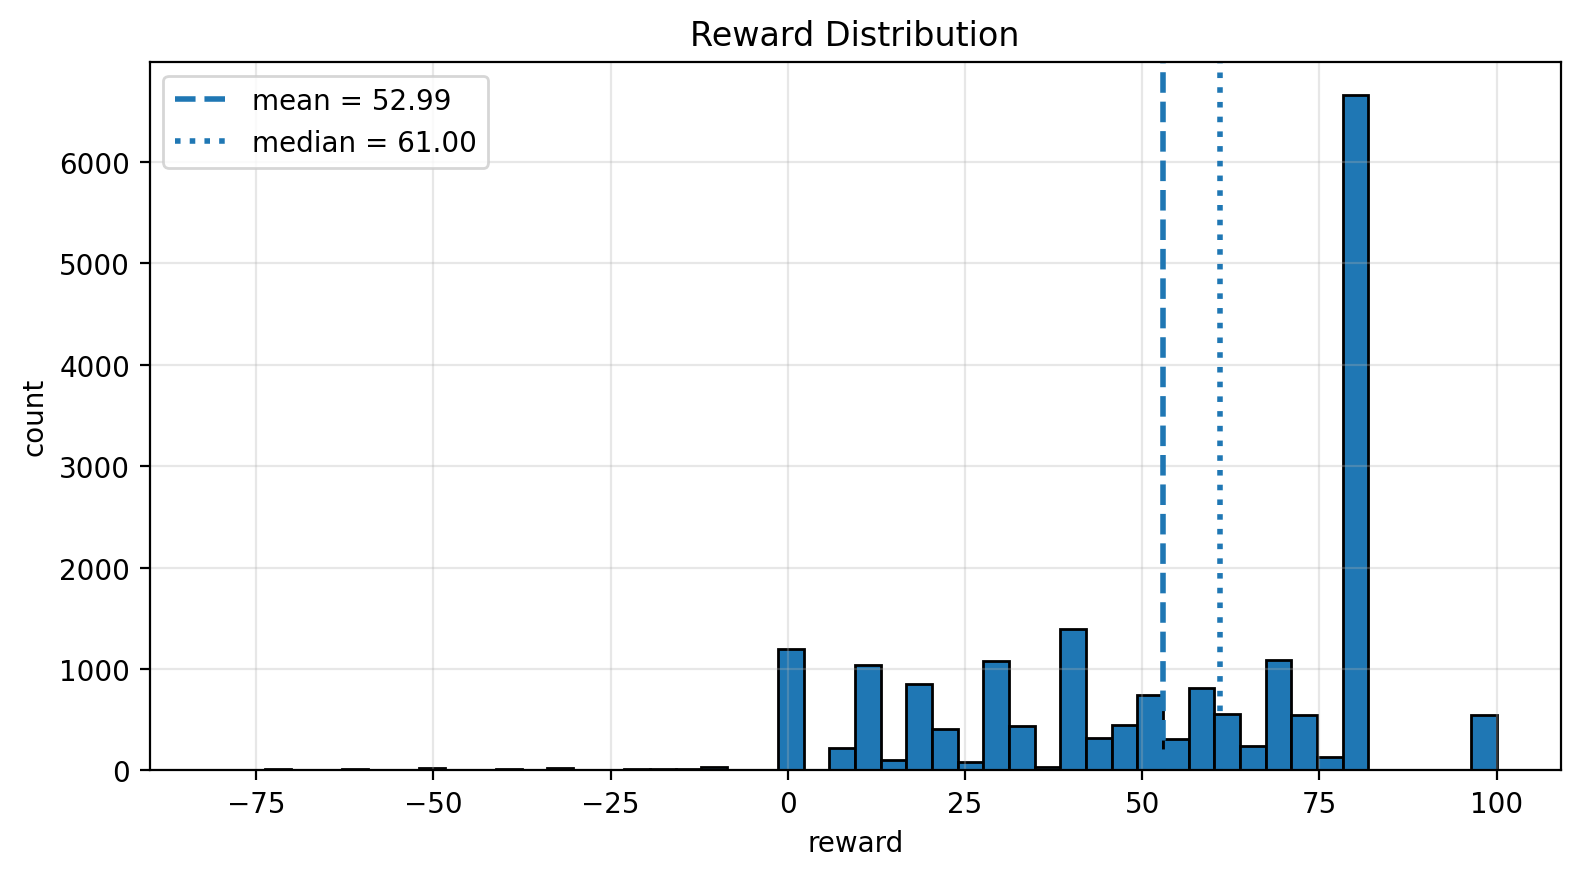

In [10]:
r = DATA["reward"].astype(float).dropna()
fig, ax = plt.subplots(figsize=(8,4.5))
bins = np.arange(r.min()-0.5, r.max()+1.5, 1) if np.allclose(r, r.round()) else "auto"
n, bins, _ = ax.hist(r, bins=bins, edgecolor="black")
ax.axvline(r.mean(),   ls="--", lw=2, label=f"mean = {r.mean():.2f}")
ax.axvline(r.median(), ls=":",  lw=2, label=f"median = {r.median():.2f}")
ax.set(title="Reward Distribution", xlabel="reward", ylabel="count")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

## From  noisy seeds

In [11]:
DATA_FILE2 = "DATA/C4.bad_play_data.xlsx"
DATA2 = pd.read_excel(DATA_FILE2)
BOARD_COLS2 = [f"{r}-{c}" for r in range(6) for c in range(7)]
DATA2[BOARD_COLS2] = DATA2[BOARD_COLS2].astype("int8")
DATA2[["reward"]].describe()

reward
count  34029.000000
mean      52.381777
std       29.672485
min      -81.000000
25%       29.500000
50%       59.250000
75%       79.000000
max      100.000000

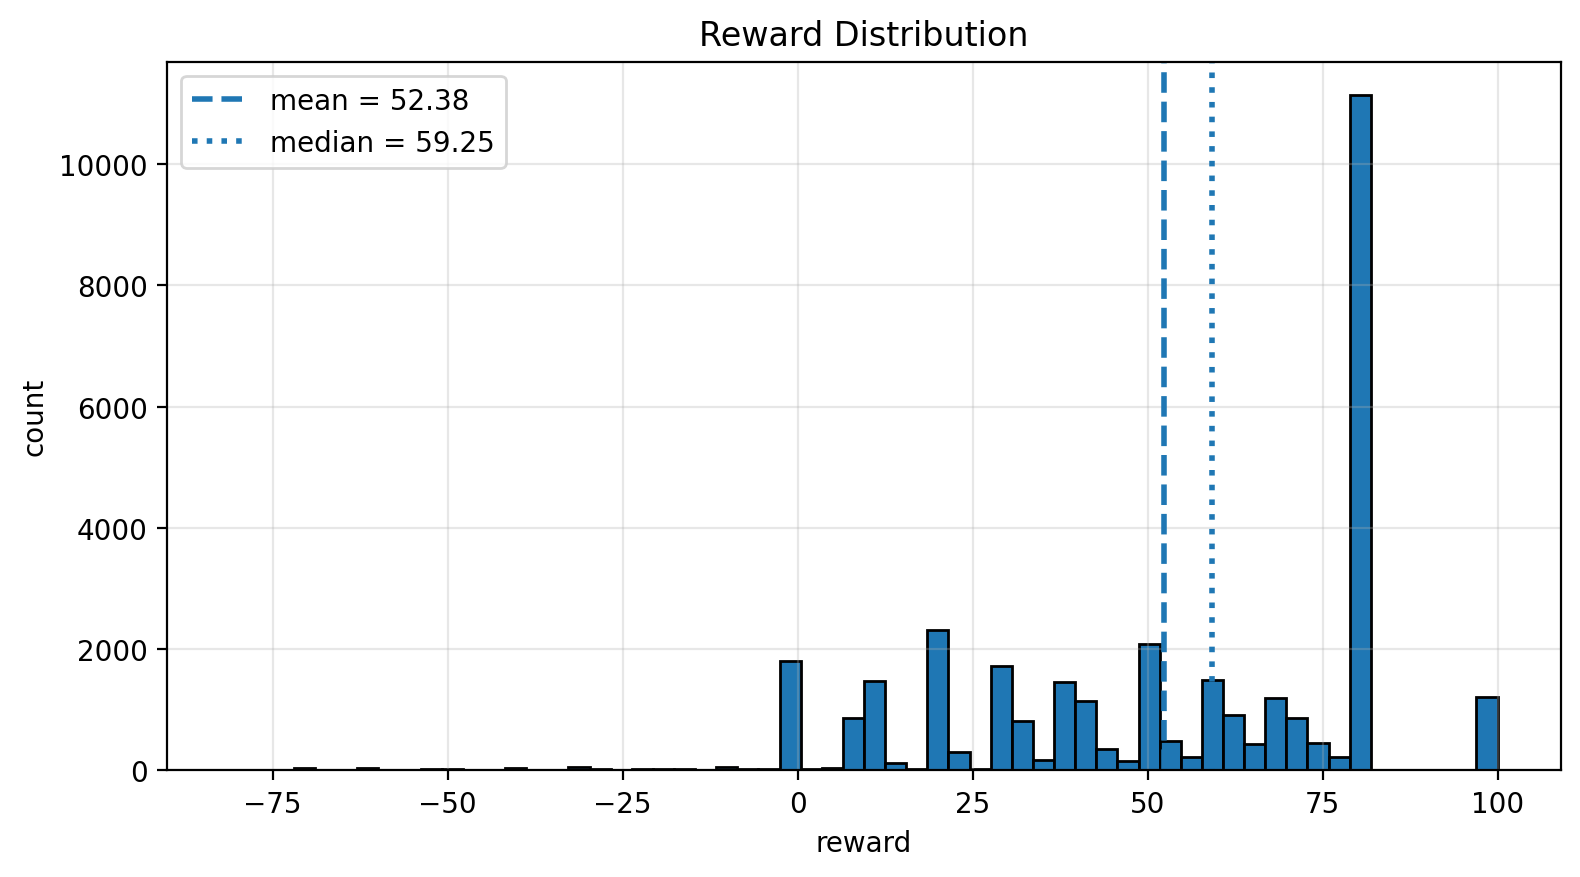

In [12]:
r = DATA2["reward"].astype(float).dropna()
fig, ax = plt.subplots(figsize=(8,4.5))
bins = np.arange(r.min()-0.5, r.max()+1.5, 1) if np.allclose(r, r.round()) else "auto"
n, bins, _ = ax.hist(r, bins=bins, edgecolor="black")
ax.axvline(r.mean(),   ls="--", lw=2, label=f"mean = {r.mean():.2f}")
ax.axvline(r.median(), ls=":",  lw=2, label=f"median = {r.median():.2f}")
ax.set(title="Reward Distribution", xlabel="reward", ylabel="count")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

## Training loop - DQN against lookahead opponent (Prophet-style)

### Training loop

#### Loading checkpoint model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cuda


In [14]:
LOAD = True
agent = DQNAgent(device=device)  # Fresh agent 
if LOAD:
    model_name=f"{model_name} DQN model.pt"
    state_dict = torch.load(model_name, map_location=device, weights_only=True)
    agent.model.load_state_dict(state_dict)
    agent.update_target_model()
    agent.epsilon = 0.0  
    print(f"✅ {model_name} loaded and ready for further training.")

✅ RANDOM III DQN model.pt loaded and ready for further training.


#### Seeding from lookahed games

In [15]:
SEEDING = True
env = Connect4Env()
N_STEP = 5 #3
nstep_buf = NStepBuffer(n=N_STEP, gamma=agent.gamma, memory=agent.memory)
if SEEDING:
    seed_start_time = time.time()
    print(f"Started seeding at {time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(seed_start_time))}, be patient ...")
    agent.memory.begin_seeding()
    nstep_buf = seed_from_dataframe_moves(nstep_buf, DATA, agent, n_step=N_STEP, gamma=agent.gamma, verbose=True)     # LA
    nstep_buf = seed_from_dataframe_moves(nstep_buf, DATA2, agent, n_step=N_STEP, gamma=agent.gamma, verbose=True)    # LA - noisy
    agent.memory.end_seeding()
    seed_end_time = time.time()
    seed_elapsed = seed_end_time - seed_start_time
    print(f"Seeding completed in {seed_elapsed:.1f} seconds")

Started seeding at 2025-10-26 16-56-14, be patient ...


Seeding:   0%|          | 0/618 [00:00<?, ?it/s]

[seed] games_added=618, steps_added=19451, failed_games=0
[seed] reward_scale=0.010000 | raw_min..max=-81.000..100.000 | scaled_min...max=-0.810...1.000


Seeding:   0%|          | 0/618 [00:00<?, ?it/s]

[seed] games_added=99, steps_added=6159, failed_games=519
[seed] reward_scale=0.010000 | raw_min..max=-81.000..100.000 | scaled_min...max=-0.810...1.000
  Failed: [('L1', 3), ('L1', 9), ('L1', 10), ('L1', 11), ('L1', 14), ('L1', 16), ('L1', 17), ('L1', 18), ('L1', 19), ('L1L2', 2)] ...
Seeding completed in 66.8 seconds


In [20]:
# quick debug
def ensure_6ch(agent, arr: np.ndarray) -> np.ndarray:
    """arr: (1,C,6,7) in numpy; returns (1,6,6,7)"""
    if arr.shape[1] == 6:
        return arr
    if arr.shape[1] == 4:
        with torch.no_grad():
            t = torch.from_numpy(arr).float().to(agent.device)
            t6 = agent.model._append_diagonals(t).cpu().numpy()
        return t6
    raise ValueError(f"expected 4 or 6 channels, got {arr.shape}")
    
def q_of_board(agent, board_2d: np.ndarray, player=1):
    """board_2d: (6,7) ints {0,1,2}"""
    s = agent.board_to_state(board_2d, player)   # may be (6,6,7) or (4,6,7); add batch dim:
    if s.ndim == 3:
        s = s[None, ...]
    s = ensure_6ch(agent, s)
    with torch.no_grad():
        q = agent.model(torch.from_numpy(s).float().to(agent.device)).cpu().numpy()[0]
    return q
    
b = np.zeros((6,7), dtype=int)

# Q on empty board
q = q_of_board(agent, b, player=1)
print("Q(empty):", np.round(q, 4), " argmax:", int(q.argmax()))

# Mirror invariance
def mirror_board(B): return np.fliplr(B)
def mirror_action(a): return 6 - a

qm = q_of_board(agent, mirror_board(b), player=1)
print("mirror argmax:", int(qm.argmax()), " should equal:", mirror_action(int(q.argmax())))


Q(empty): [0.0799 0.0658 0.0694 0.0791 0.0829 0.0715 0.0764]  argmax: 4
mirror argmax: 4  should equal: 2


In [ ]:
ok = agent.mirror_consistency_probe(env)


In [16]:
summary_stats = {}  
reward_history = []
win_history = []
epsilon_history = []
epsilon_min_history = []
memory_prune_low_history = []

win_count = loss_count = draw_count = 0
phase = None
frozen_opp = None
strategy_weights = []
benchmark_history = None
BENCHMARK_EVERY = 10 #20
opening_kpis = init_opening_kpis()
tu_interval_history, tau_history, tu_mode_history = [], [], []
guard_prob_history = []
center_prob_history = []

openings = OpeningTracker(cols=7, log_every=plot_interval, ma_window=12)

### Live plots

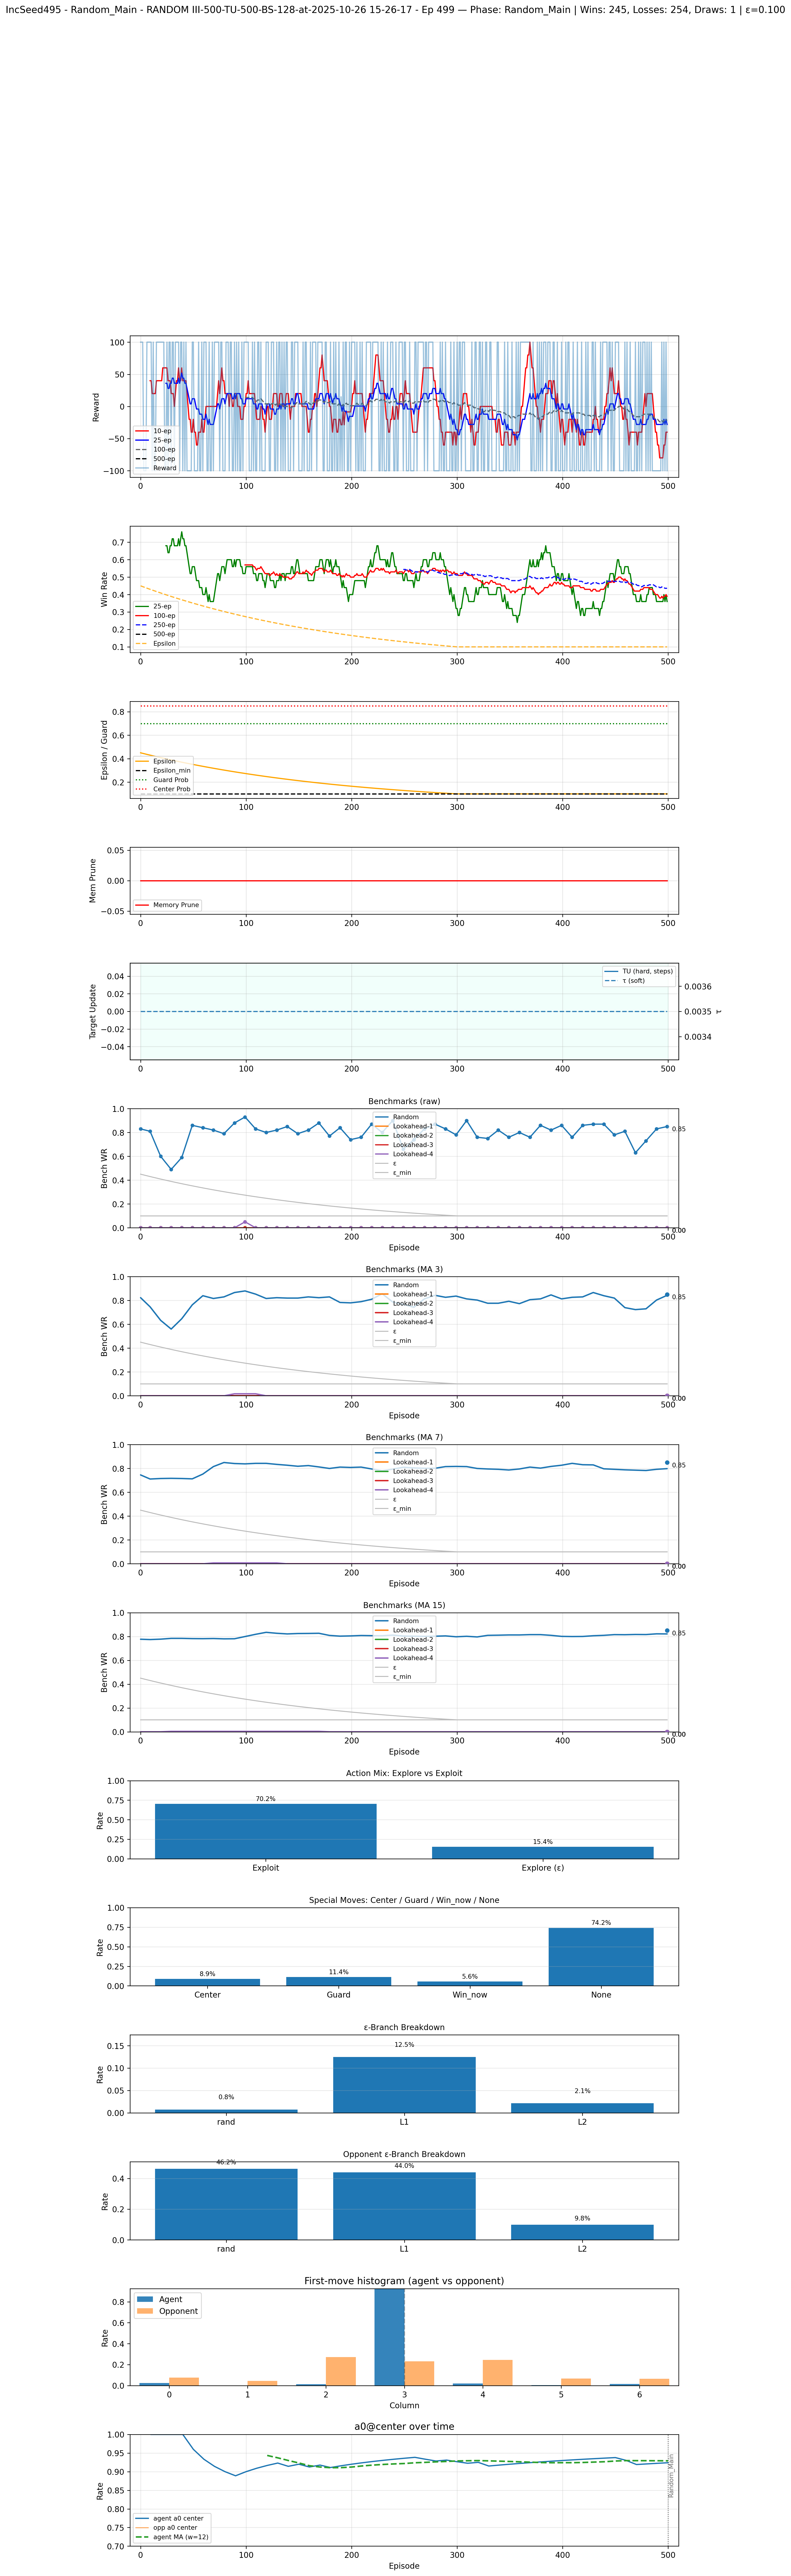

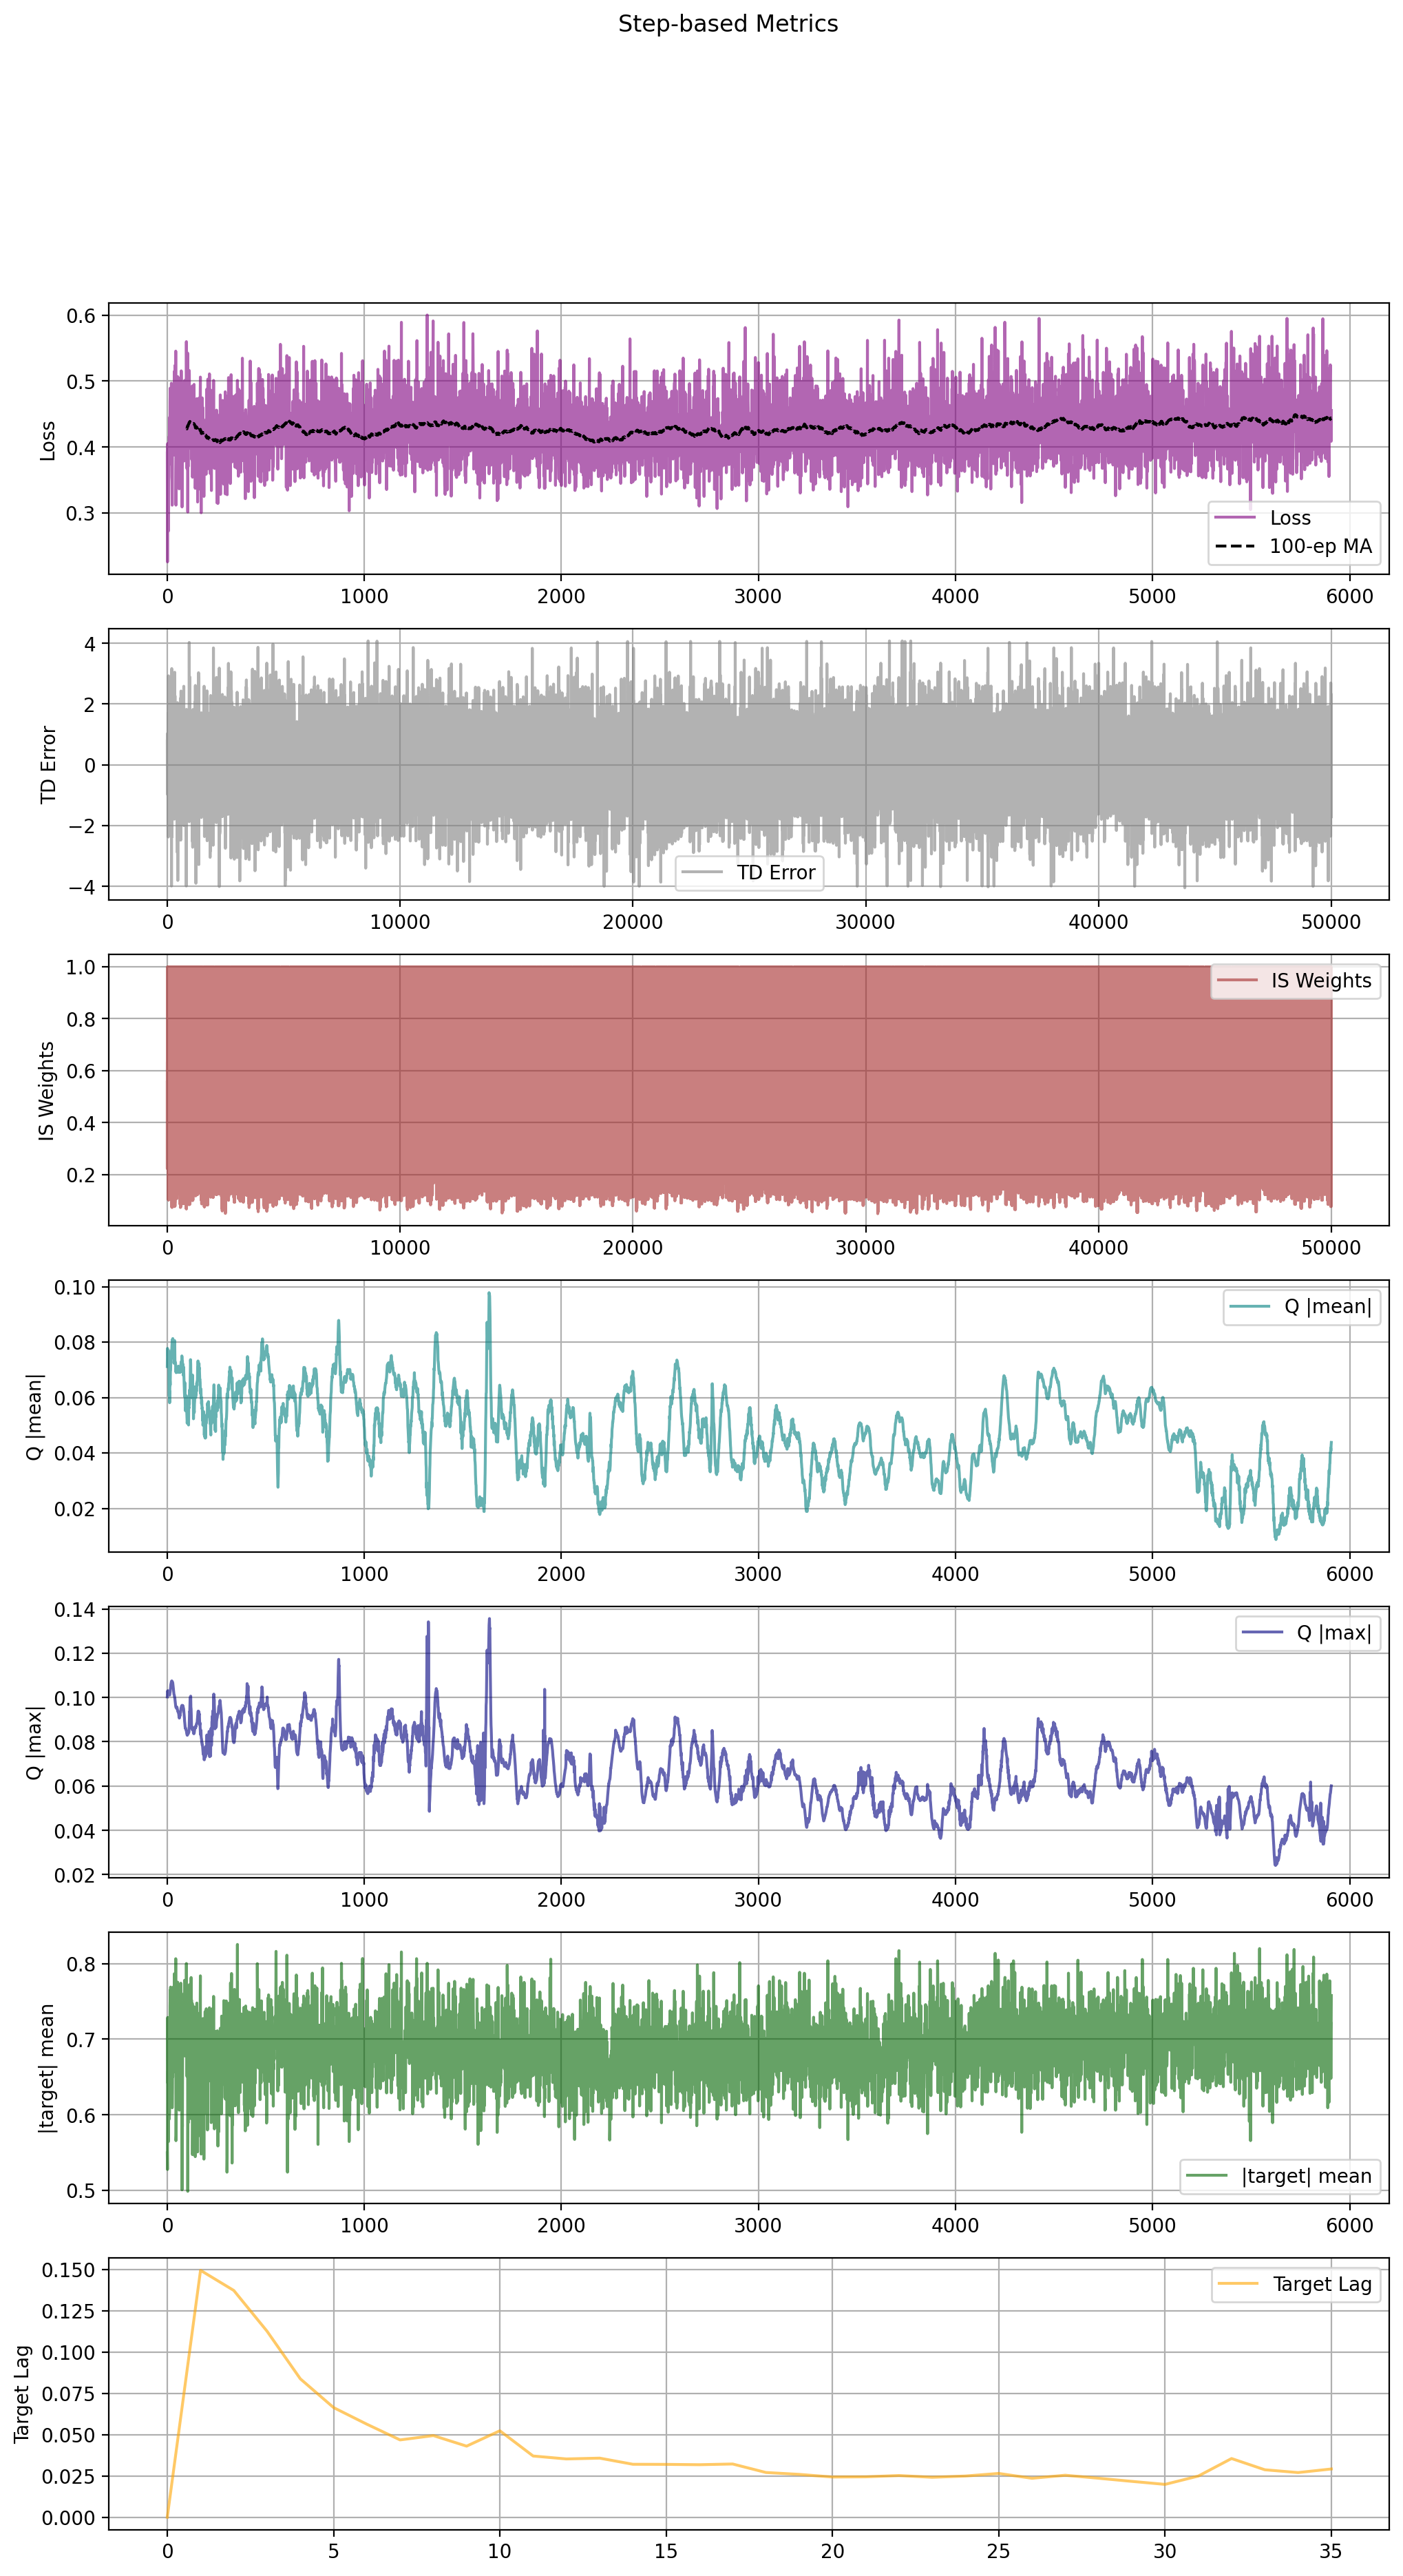

In [17]:
plots_handle = display(None, display_id=True)   
steps_handle = display(None, display_id=True)

fig_ep = None 
fig_step = None

In [18]:
# === Training loop  ===

start_time = time.time()
env_steps = 0

with tqdm(total=num_episodes, desc="Training Episodes", leave=True, dynamic_ncols=True) as pbar:
    for episode in range(num_episodes):
        
        state = env.reset()
        nstep_buf.reset()                                    # important: clear rolling window per episode
        ply_idx = 0
        total_reward = 0.0                                   # terminal reward only
        final_result = None                                  # 1 win, -1 loss, 0.5 draw
        agent.center_forced_used = False                     # reset - new episode
        
        # --- handle phase & hyperparams ---   
        new_phase, strategy_weights, epsilon, memory_prune_low, epsilon_min, target_update_interval, \
                TU_mode, TU_tau, guard_prob, center_start, min_seed_fraction, max_seed_fraction , lr = get_phase(episode)
        
        phase_changed = new_phase != phase

        # --- save checkpoint on phase change ---
        if phase_changed and phase is not None:
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Temp_Connect4 dqn_model_{timestamp} episodes-{episode+1} phase-{phase}.pt"
            default_model_path = f"phase-{phase} Interim Connect4 DQN model.pt"
            torch.save(agent.model.state_dict(), model_path)
            torch.save(agent.model.state_dict(), default_model_path)
            print(f"Temp Model saved to {model_path}")

        # -------------------------------------------
        phase, frozen_opp = handle_phase_change(agent, new_phase, phase, epsilon, memory_prune_low, epsilon_min, frozen_opp,
            env, episode, device, Lookahead, TRAINING_SESSION, guard_prob, center_start, min_seed_fraction, max_seed_fraction, lr)

        prev_mode = getattr(agent, "target_update_mode", None)
        prev_tu   = getattr(agent, "target_update_interval", None)
        
        if phase_changed or (TU_mode != prev_mode) or (target_update_interval != prev_tu):
            agent.reset_target_update_timer(env_steps)
            agent.guard_prob = guard_prob
            agent.center_start = center_start 
            agent.target_update_mode = TU_mode
            agent.tau = TU_tau
            agent.set_target_update_interval(target_update_interval)
            agent.update_target_model() 
            
        if phase_changed and openings is not None: openings.mark_phase(episode + 1, new_phase)

        # --------------------------------------------------------------------------------- main training loop ---------
        
        # alternating start, maybe oppo moves first
        state, _, ply_idx, env_steps = maybe_opponent_opening(env, agent, episode, state,
            phase=phase, frozen_opp=frozen_opp, lookahead_depth=lookahead_depth,
            nstep_buf=nstep_buf, ply_idx=ply_idx, opening_kpis=opening_kpis, openings=openings, env_steps=env_steps)

        assert not env.done, "Unexpected terminal state after opening move. Luckily this shit never happens. Right? Right?? Fuuuck!"

        # Turn-by-turn until terminal
        while not env.done:
            # --- Agent (+1) acts ---
            state, done, ply_idx, env_steps = agent_move_step(env, agent, state,
                ply_idx=ply_idx, lookahead_depth=lookahead_depth, strategy_weights=strategy_weights,
                nstep_buf=nstep_buf, opening_kpis=opening_kpis, openings=openings, env_steps=env_steps)
            
            if done:
                _, final_result, total_reward = finalize_if_done(env)
                break

            # --- Opponent (-1) responds ---
            state, done, ply_idx, env_steps = opponent_move_step(env, agent, episode, state,
                phase=phase, frozen_opp=frozen_opp, lookahead_depth=lookahead_depth,
                nstep_buf=nstep_buf, ply_idx=ply_idx, opening_kpis=opening_kpis, openings=openings, env_steps=env_steps)
            
            if done:
                _, final_result, total_reward = finalize_if_done(env)
                break

        # ------------------------------------------------------------- Episode ended — flush remaining short tails ---------
        
        nstep_buf.flush()

        # --- Training updates ---

        mem_len = len(agent.memory)
        MIX = getattr(agent, "per_mix_1step", 0.70)
        WARMUP_HALF = max(batch_size * 2, 256)
        WARMUP_FULL = max(batch_size * 5, 1024)
        
        if mem_len >= WARMUP_FULL:
            # Full batches
            updates = 4 + min(12, env.ply // 2)                                       # 4..16 updates per episode
            for _ in range(updates): agent.replay(batch_size, mix_1step=MIX)
        
        elif mem_len >= WARMUP_HALF:
            # Smaller batches
            b = max(32, min(batch_size, mem_len // 16))                               # adaptive mini-batch
            updates = 2 + min(6, env.ply // 3)                                        # 2..8 updates
            for _ in range(updates): agent.replay(b, mix_1step=MIX)
        
        else: 
            if mem_len >= 64: 
                for _ in range(2): 
                    agent.replay(32, mix_1step=MIX)

        # --------- history bookkeeping ---------
        epsilon_history.append(agent.epsilon)
        epsilon_min_history.append(agent.epsilon_min)
        reward_history.append(total_reward)
        memory_prune_low_history.append(memory_prune_low)
        guard_prob_history.append(agent.guard_prob)
        center_prob_history.append(agent.center_start)
        tu_interval_history.append(agent.target_update_interval)
        tau_history.append(agent.tau)
        tu_mode_history.append(agent.target_update_mode)
        openings.maybe_log(episode + 1)

        # Epsilon decay (per episode)
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
            agent.epsilon = max(agent.epsilon, agent.epsilon_min)

        # Win/loss/draw counters
        wins, losses, draws = track_result(final_result, win_history)
        win_count += wins
        loss_count += losses
        draw_count += draws

        # periodic benchmarking
        if (episode + 1) % BENCHMARK_EVERY == 0 or episode == 0:
            benchmark_history = update_benchmark_winrates(agent, env, device, Lookahead, episode, benchmark_history,
                save=f"{LOG_DIR}DQN-{TRAINING_SESSION}-benchmark.xlsx")

        #### Live plot ###
        # rewards and co
        if (episode + 1) % plot_interval == 0:
            avg_reward = np.mean(reward_history[-25:]) if len(reward_history) >= 1 else 0.0
            pbar.set_postfix(avg_reward=f"{avg_reward:.2f}", epsilon=f"{agent.epsilon:.3f}", wins=win_count, losses=loss_count, draws=draw_count, 
                             phase=phase)

            fig_ep, fig_step = plot_live_training(
                episode, reward_history, win_history, epsilon_history,
                phase, win_count, loss_count, draw_count, TRAINING_SESSION,
                epsilon_min_history, memory_prune_low_history, agent=agent,
                bench_history=benchmark_history, bench_smooth_k=3,
                tu_interval_history=tu_interval_history,
                tau_history=tau_history,
                tu_mode_history=tu_mode_history,
                guard_prob_history=guard_prob_history, center_prob_history=center_prob_history,
                openings=openings,
                return_figs=True
            )

        if fig_ep is not None:
            plots_handle.update(fig_ep)   
            plt.close(fig_ep)
            
        if fig_step is not None:
            steps_handle.update(fig_step)
            plt.close(fig_step)

        # Periodic logging
        if (episode + 1) % log_every_x_episode == 0:
            log_summary_stats(episode=episode, reward_history=reward_history, win_history=win_history, phase=phase,
                strategy_weights=strategy_weights, agent=agent, win_count=win_count, loss_count=loss_count,
                draw_count=draw_count, summary_stats_dict=summary_stats)
            
            open_summary = summarize_opening_kpis(opening_kpis)
            summary_stats["openings"] = {
                "summary": open_summary,
                "episodes": openings.episodes,
                "agent_center_rate": openings.a_center_rates,
                "opp_center_rate": openings.o_center_rates,
            }
            
        pbar.update(1)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / num_episodes:.2f} s/episode)")


Training Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/40 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]


Training completed in 63.5 minutes (7.62 s/episode)


In [19]:
summarize_opening_kpis(opening_kpis)

{'a0_center_rate': 0.924, 'o0_center_rate': 0.232, 'a0_mode': 3, 'o0_mode': 2}

## Final training plot

In [20]:
 plot_live_training(episode, reward_history, win_history, epsilon_history, 
                    phase, win_count, loss_count, draw_count, TRAINING_SESSION,
                    epsilon_min_history, memory_prune_low_history,agent=agent,
                    save = True, path= PLOTS,
                    bench_history=benchmark_history, bench_smooth_k=3,
                    tu_interval_history=tu_interval_history,
                    tau_history=tau_history,
                    tu_mode_history=tu_mode_history,
                    guard_prob_history=guard_prob_history, center_prob_history=center_prob_history,
                    openings=openings,
                    return_figs=False
                   )

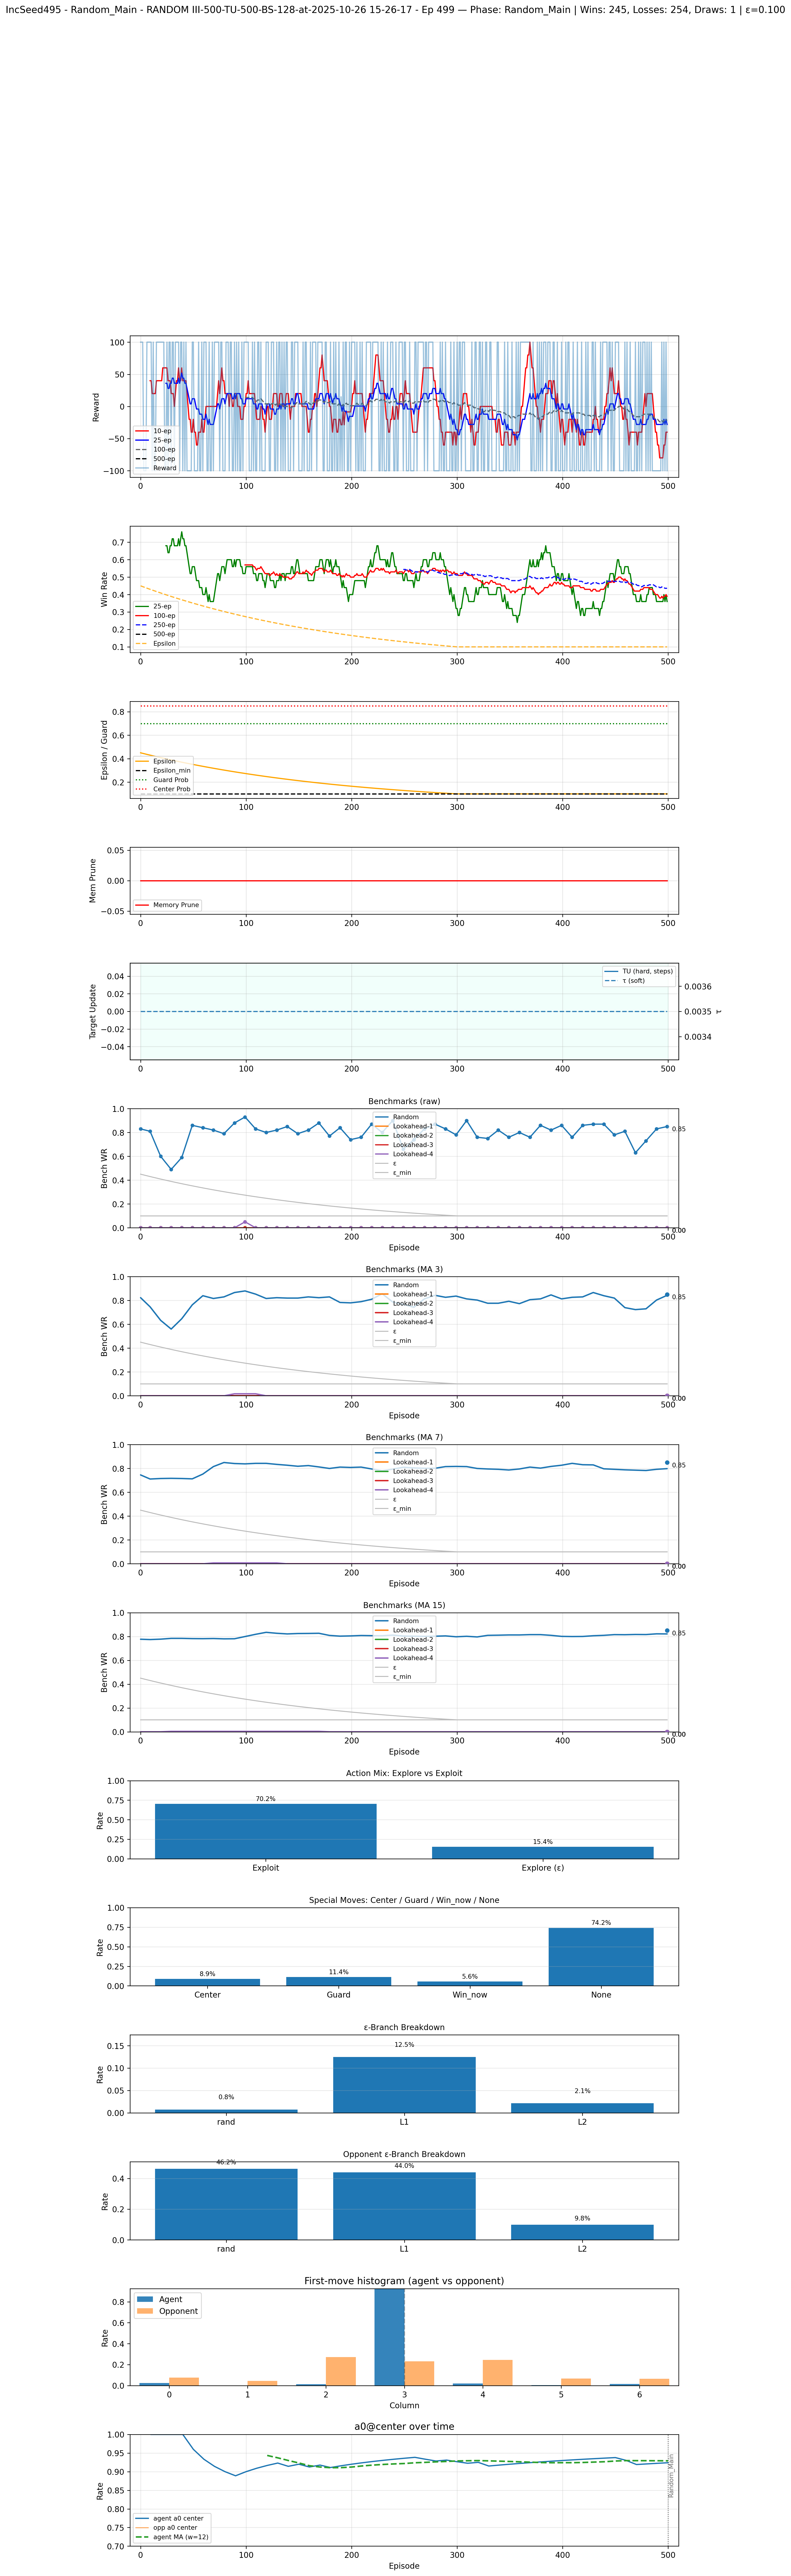

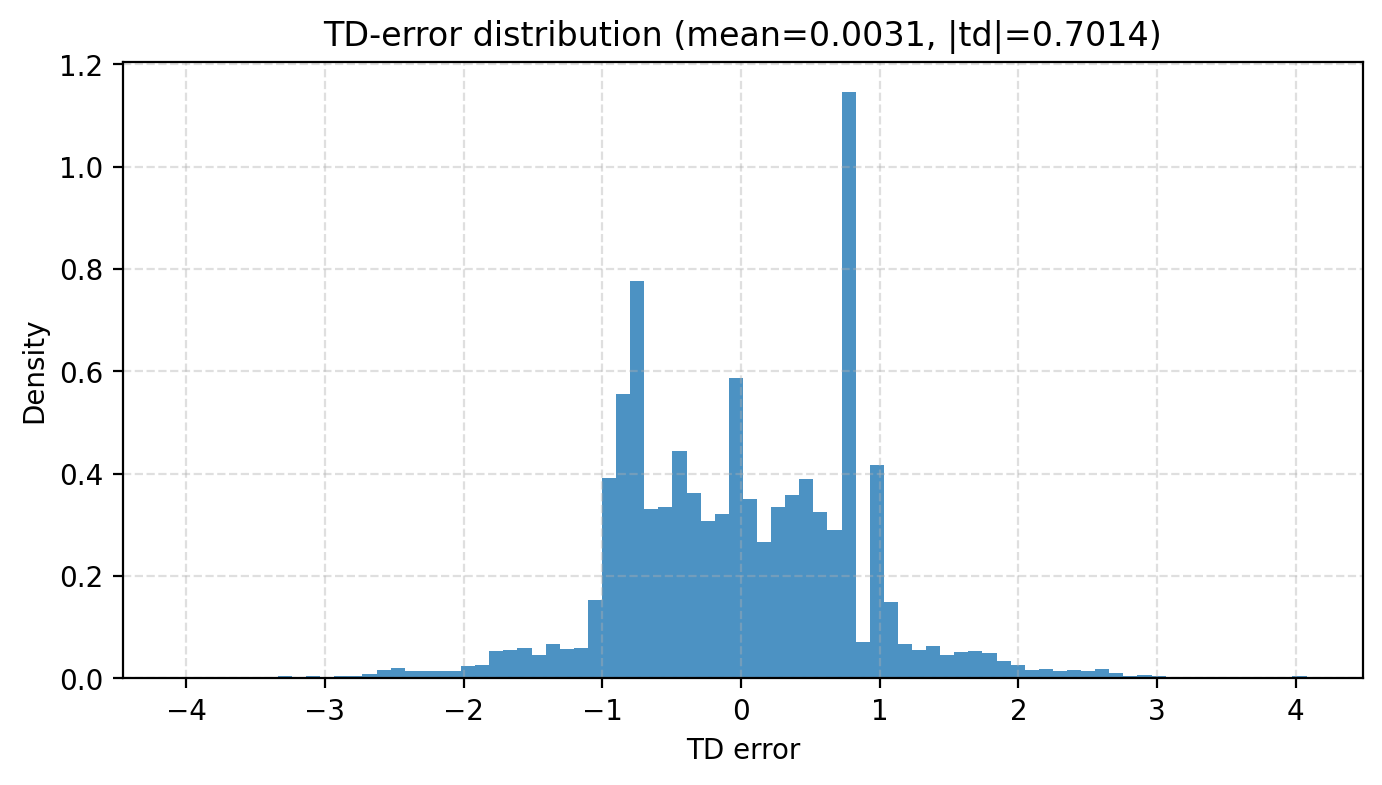

In [21]:
plot_td_error_hist(agent)

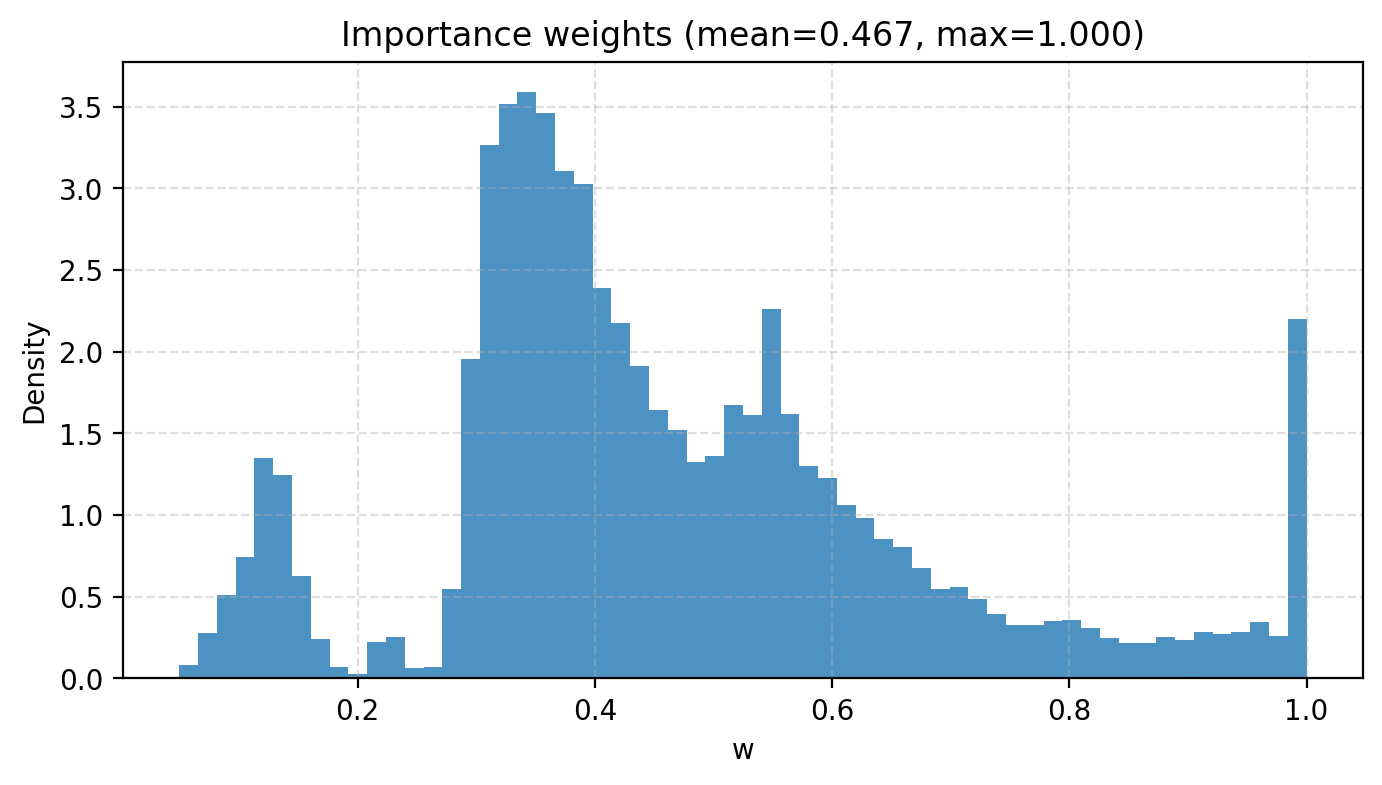

In [22]:
plot_is_weights(agent)

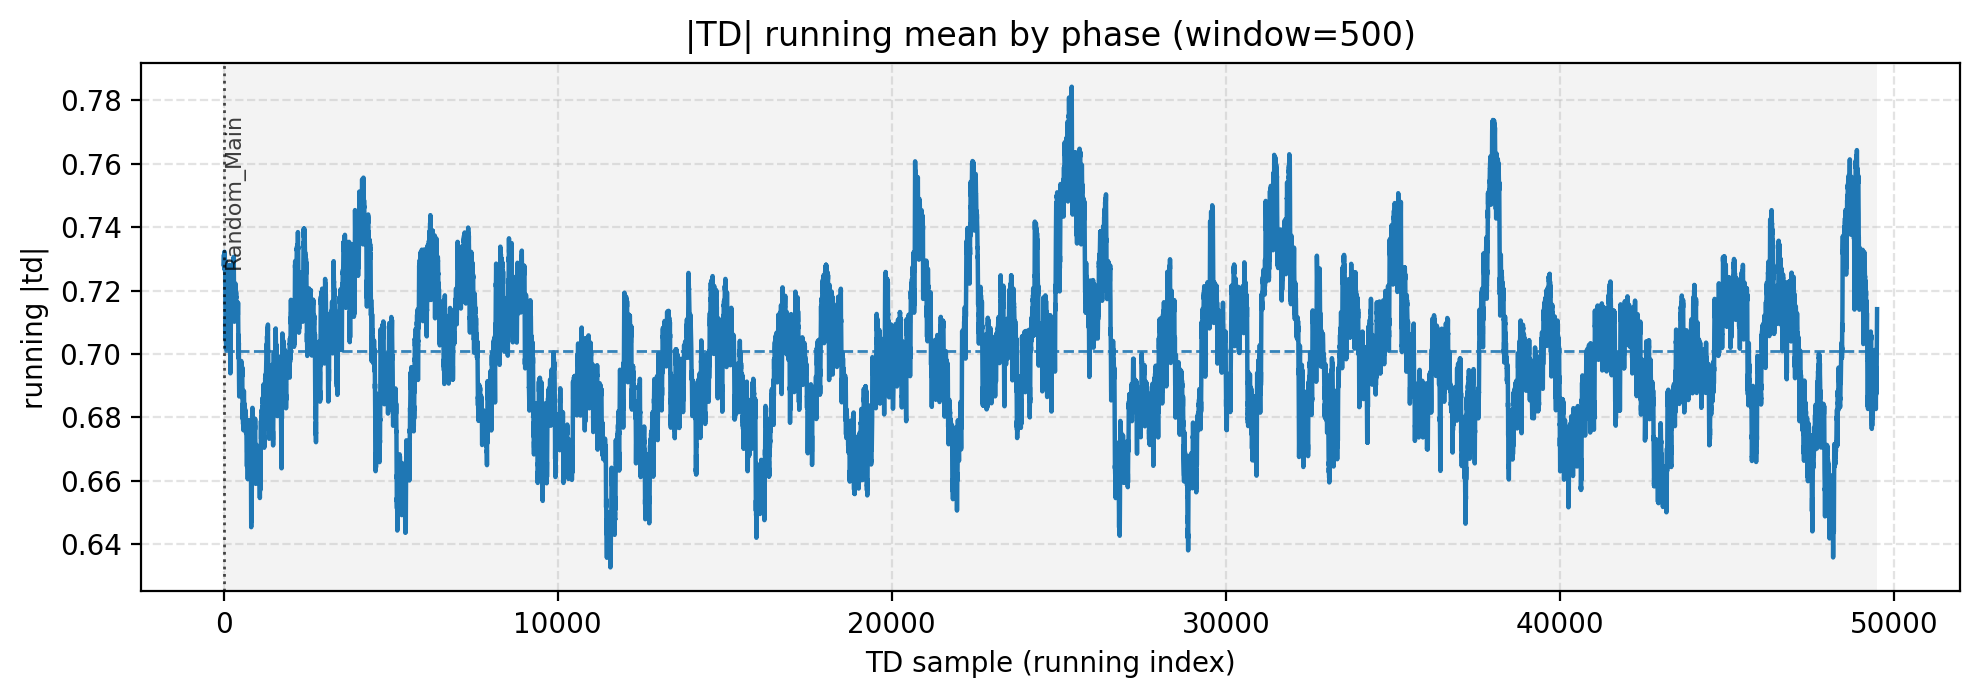

In [23]:
plot_td_running_by_phase(agent,TRAINING_PHASES, window = 500)

In [24]:
# --- Save final Win Rate plot ---
save_final_winrate_plot(win_history=win_history, training_phases=TRAINING_PHASES, save_path=PLOTS, session_name=TRAINING_SESSION)
print(f"Win rate plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_winrate.png")

Win rate plot saved to Plots/DQN/DQN-IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 15-26-17_final_winrate.png


In [25]:
print(f"\nSummary stats (every {log_every_x_episode} episodes):")
pd.DataFrame.from_dict(summary_stats, orient='index').to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-training_summary.xlsx", index=True)


Summary stats (every 100 episodes):


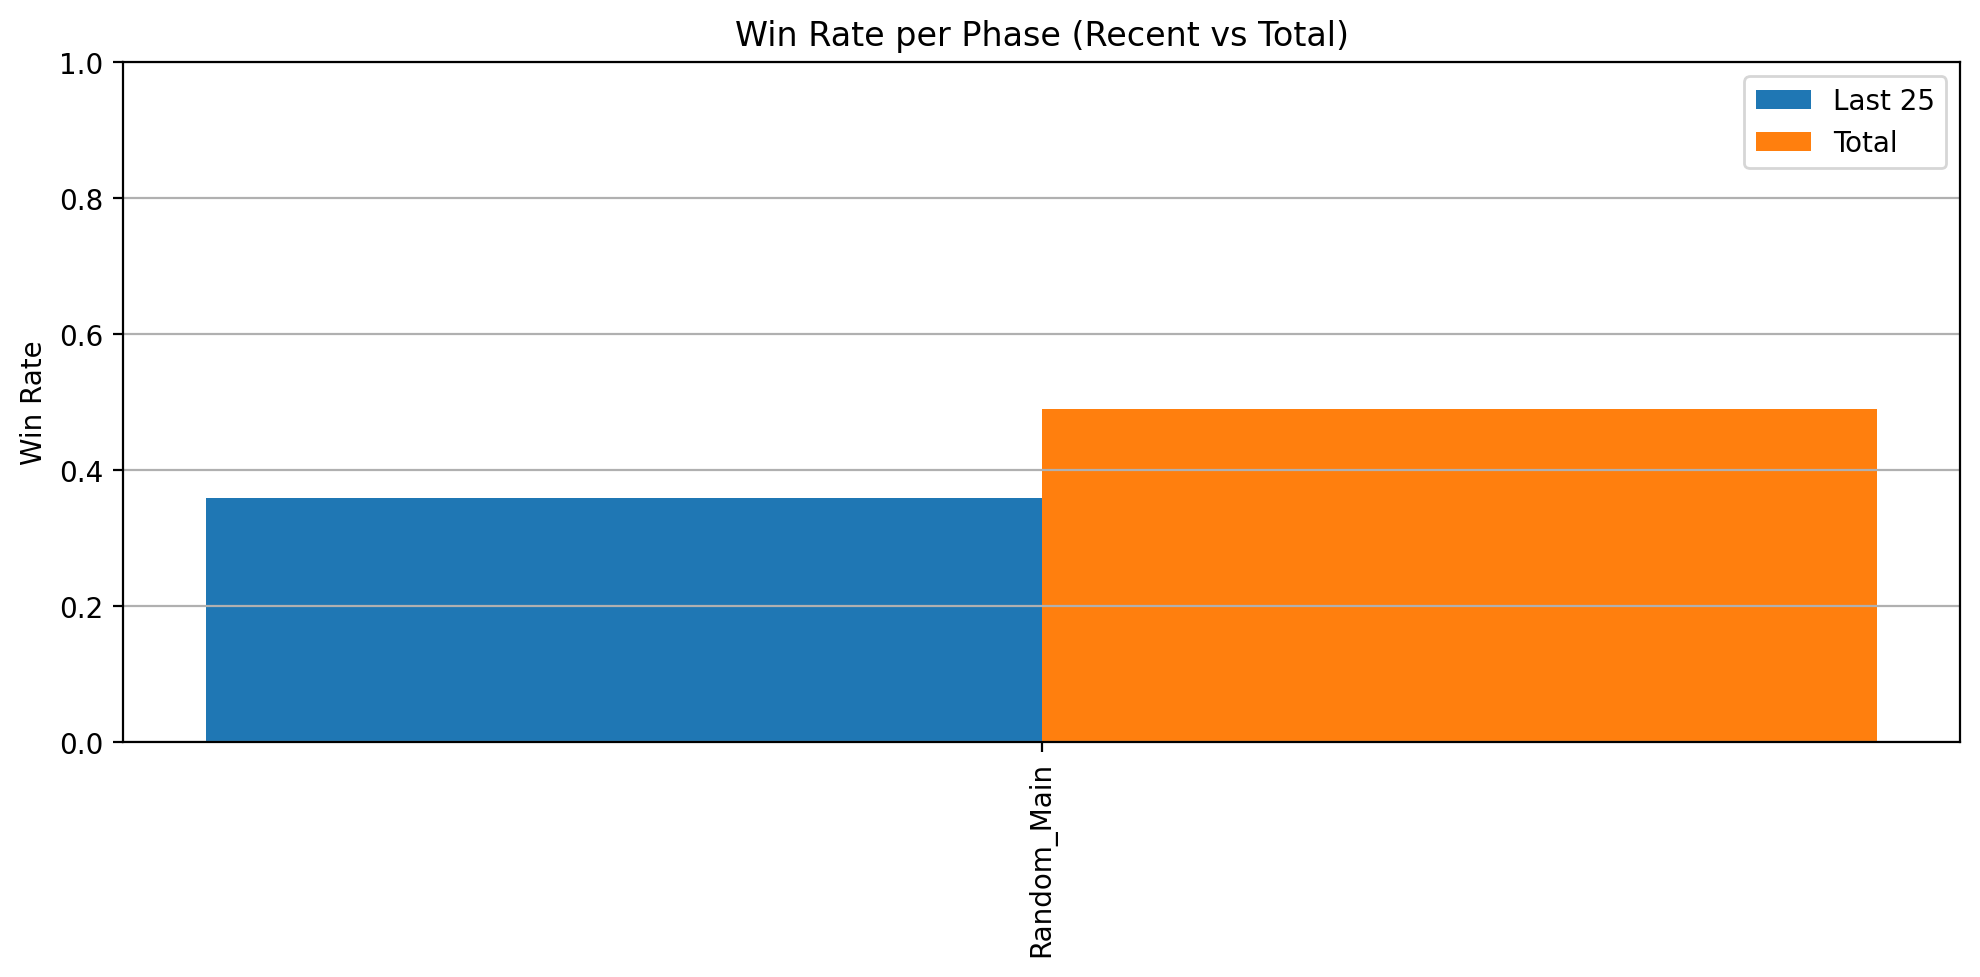

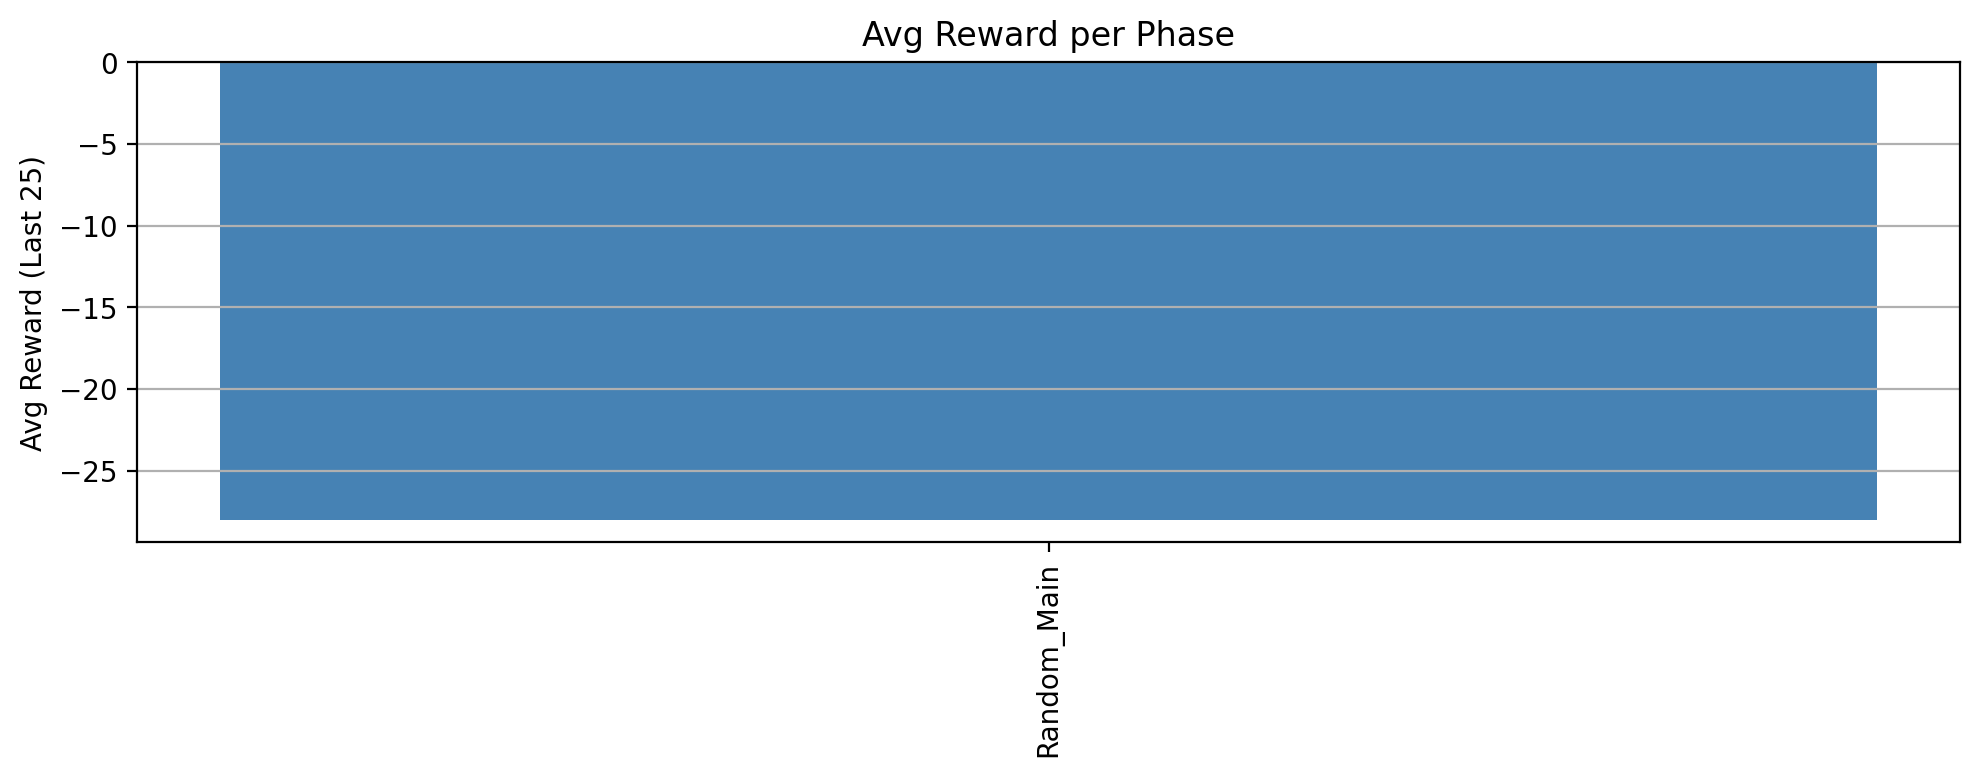

In [26]:
plot_phase_summary(summary_stats, TRAINING_PHASES)

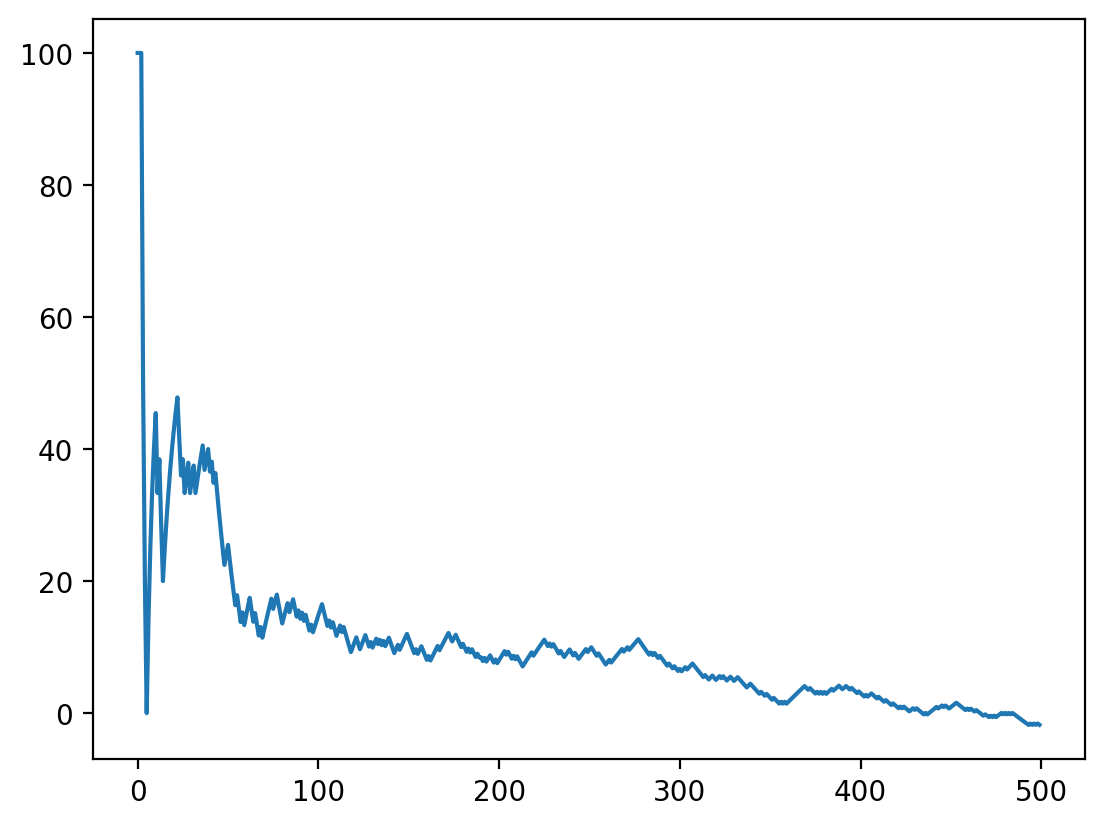

In [27]:
window = 1000
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

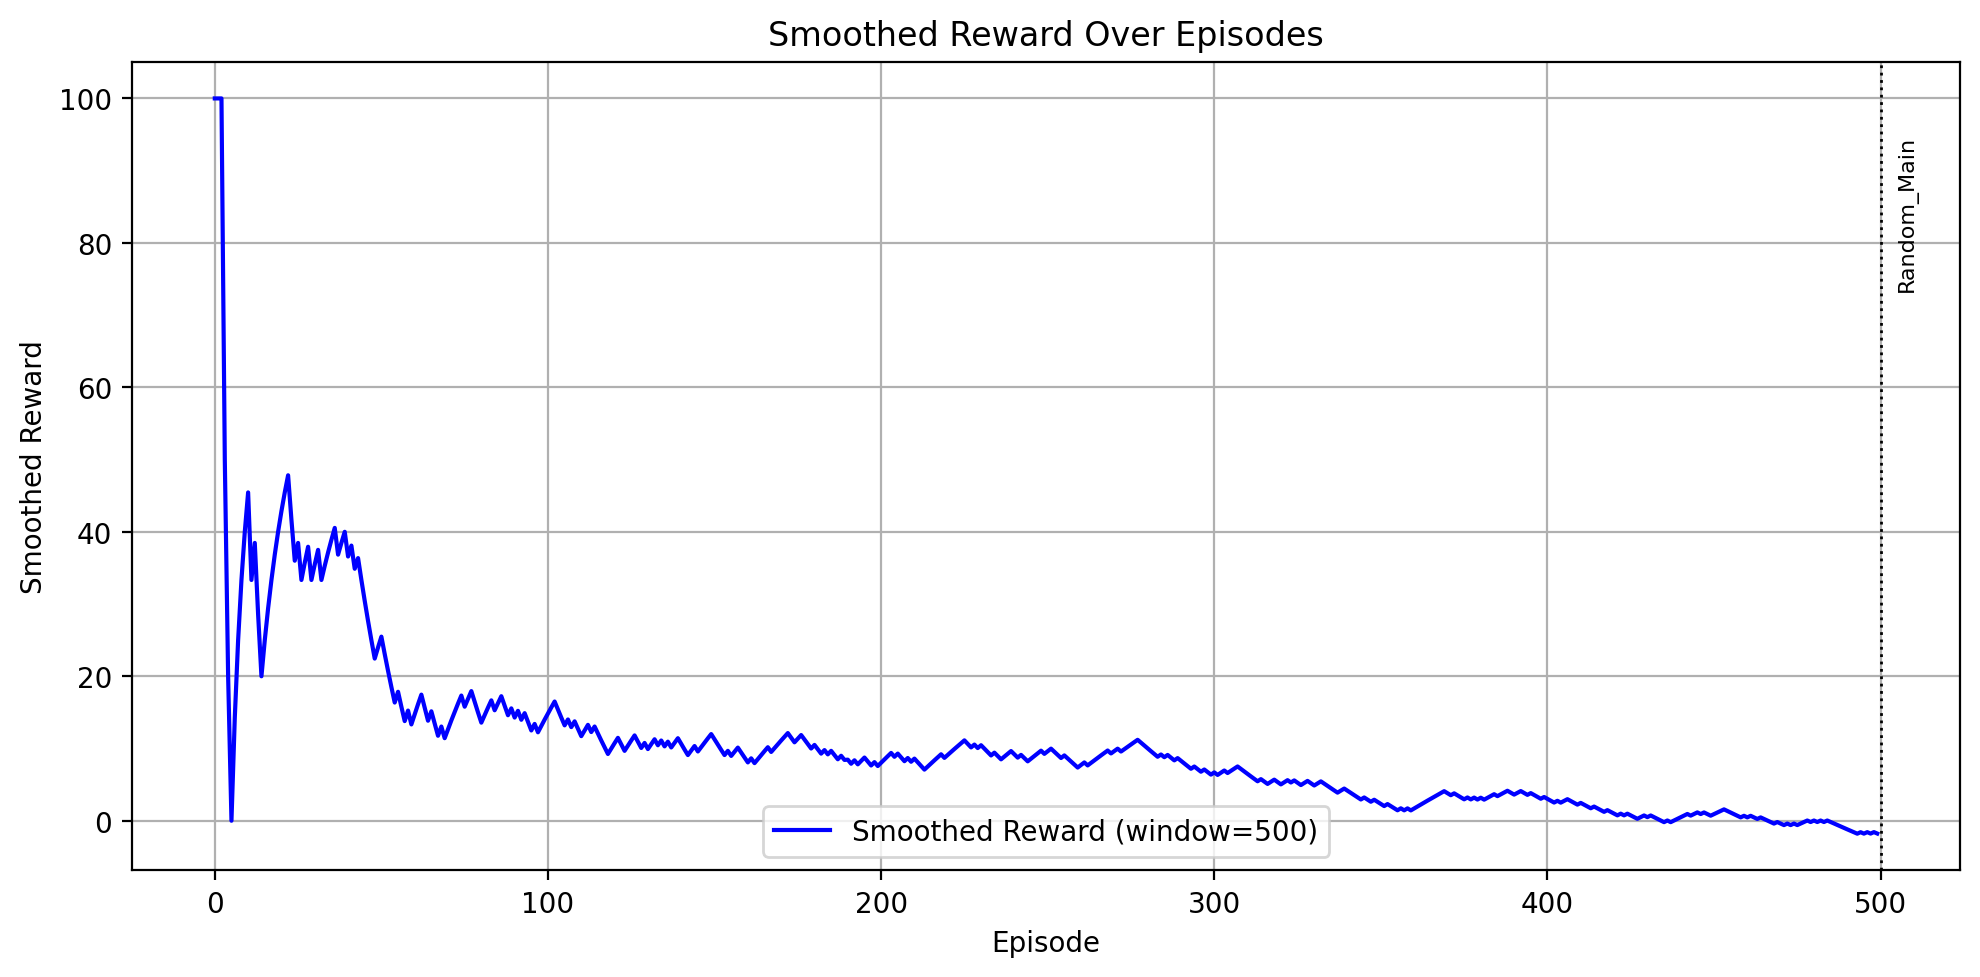

Smoothed reward plot saved to Plots/DQN/DQN-IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 15-26-17_final_reward_smoothed.png


In [28]:
window = 500
smoothed = [np.mean(reward_history[max(0, i - window):i + 1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

# --- Show plot ---
plt.show()

# --- Save to file ---
final_reward_fig.savefig(f"{PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")
plt.close(final_reward_fig)
print(f"Smoothed reward plot saved to {PLOTS}DQN-{TRAINING_SESSION}_final_reward_smoothed.png")


# Evaluation

In [29]:
# === Pure-model evaluation ===
env.reset()
evaluation_results = evaluate_agent_model(agent, env, EVALUATION_OPPONENTS, device, Lookahead)

Opponent: Random:   0%|          | 0/200 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-5:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Evaluation Summary:
Random: 156W / 44L / 0D → Win: 78.0%, Loss: 22.0%, Draw: 0.0%
Lookahead-1: 0W / 100L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-2: 0W / 50L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-3: 0W / 50L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-4: 0W / 30L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
Lookahead-5: 0W / 20L / 0D → Win: 0.0%, Loss: 100.0%, Draw: 0.0%
📊 Plot saved to Plots/DQN/DQN-IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 15-26-17-evaluation_plot.png


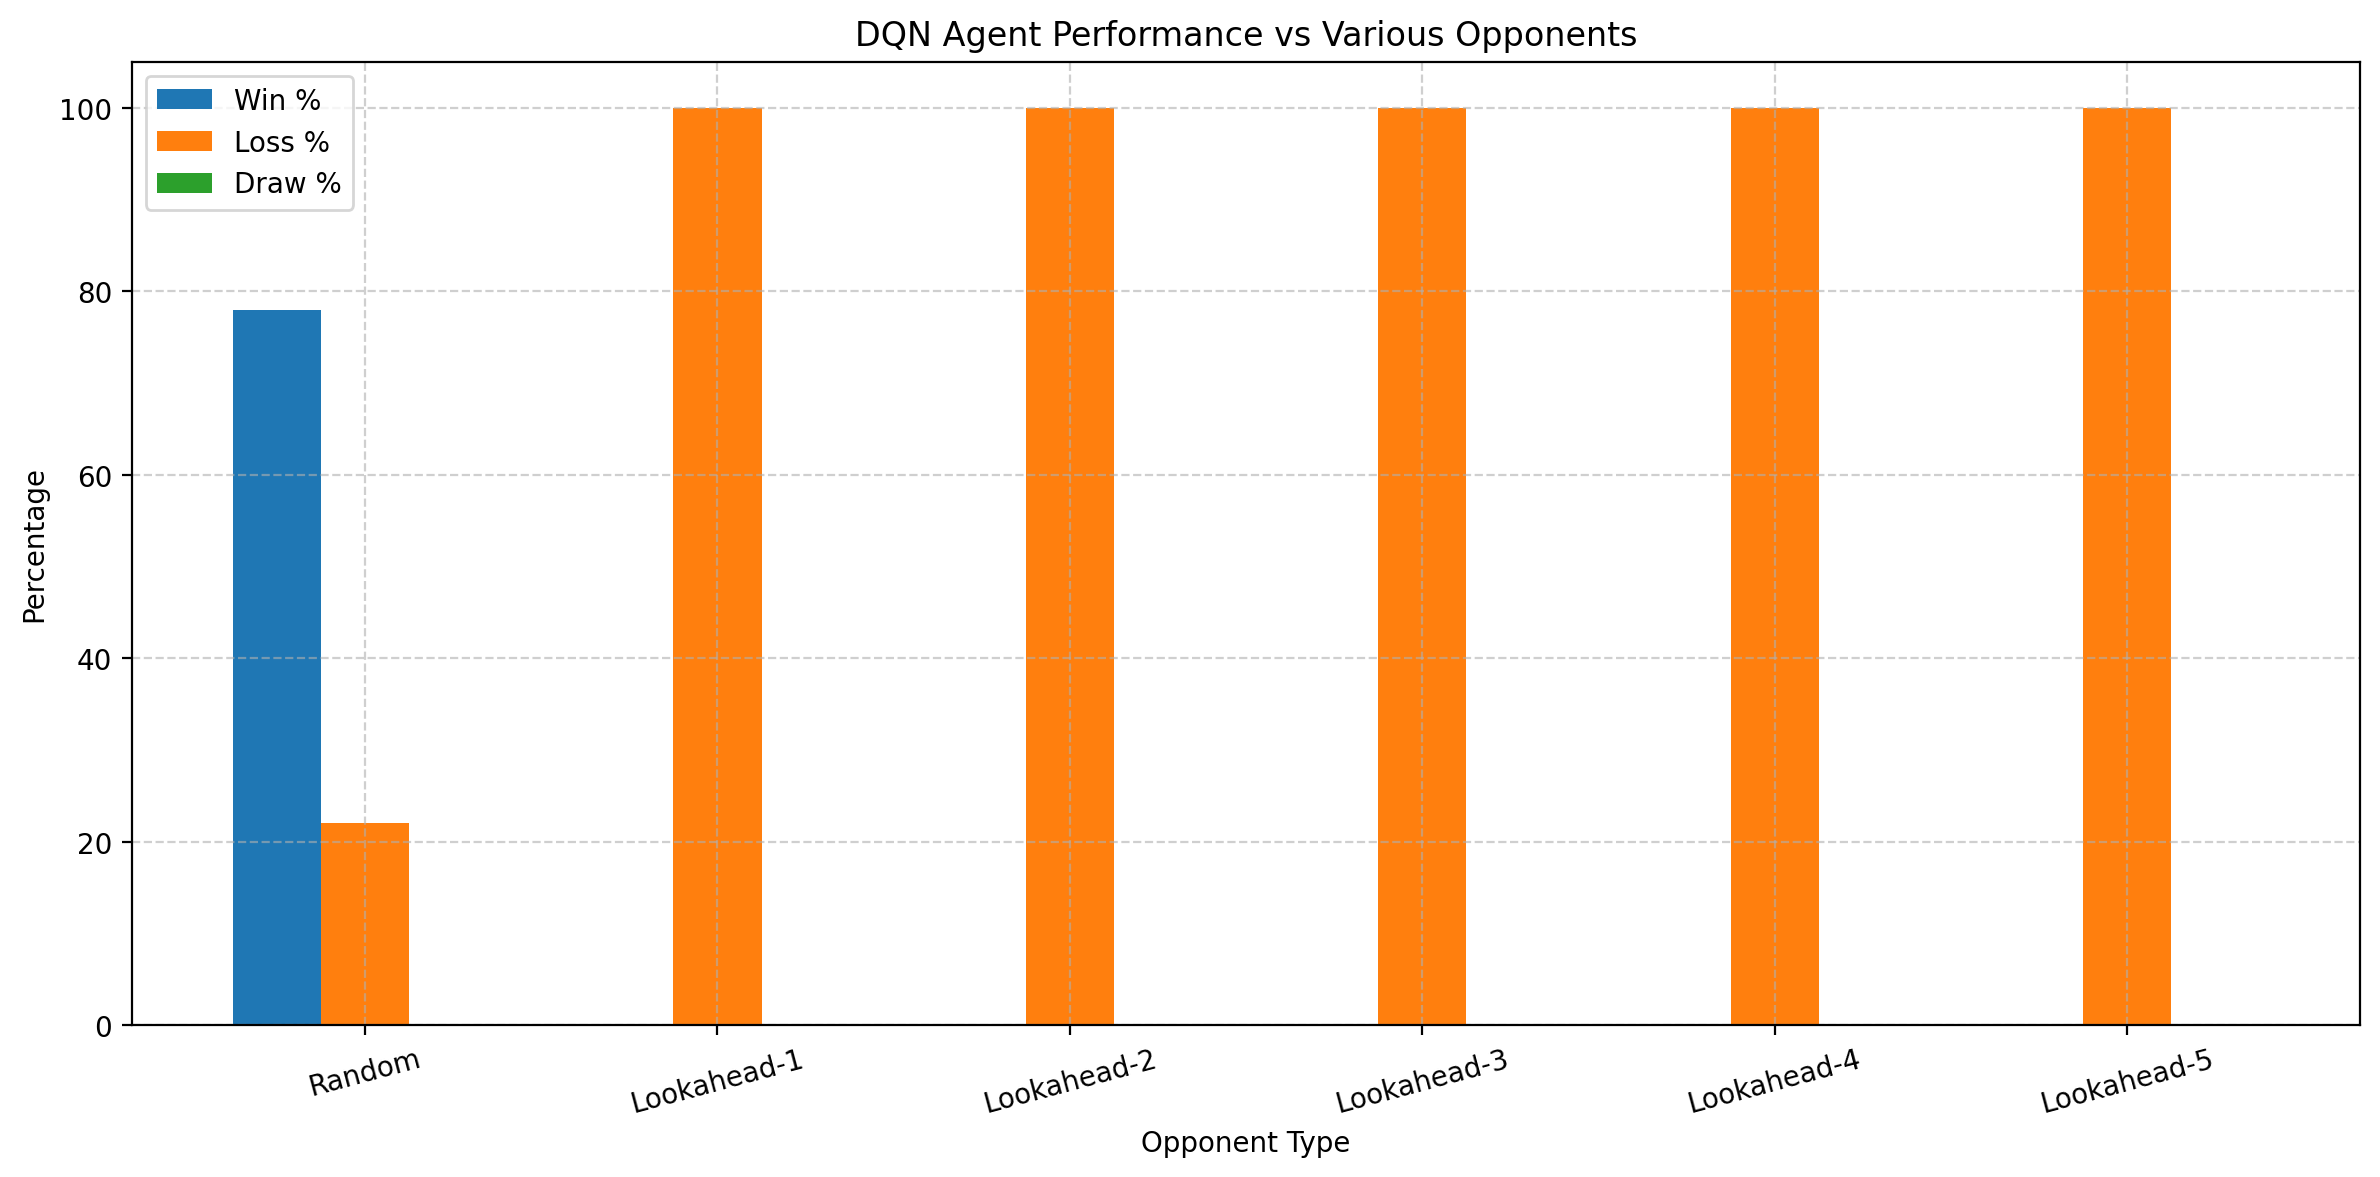

In [30]:
# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draw: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate']  * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('DQN Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_path = f"{PLOTS}DQN-{TRAINING_SESSION}-evaluation_plot.png"
plt.savefig(plot_path, dpi=150)
print(f"📊 Plot saved to {plot_path}")

plt.show()

# Save results
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
# Use Excel if available; otherwise fall back to CSV
try:
    df_eval.to_excel(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.xlsx", index=True)
except Exception as e:
    print("Excel export failed, saving CSV instead:", e)
    df_eval.to_csv(f"{LOG_DIR}DQN-{TRAINING_SESSION}-evaluation_results.csv", index=True)


### Boards


🎯 Opponent: Random


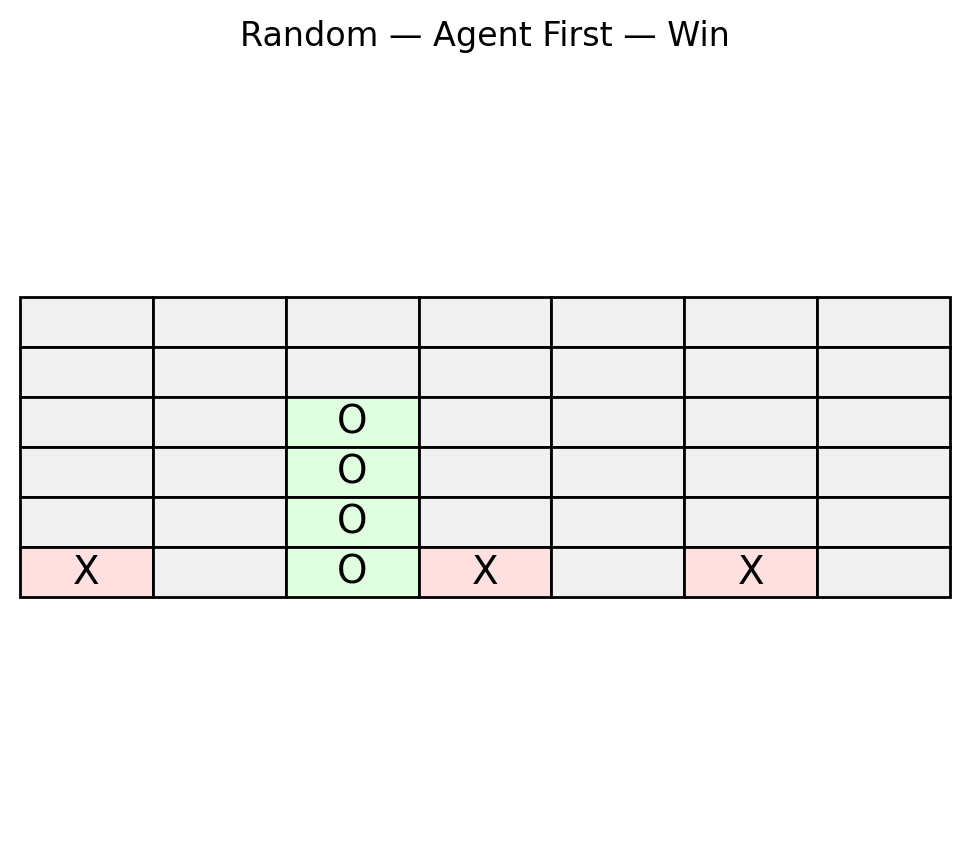

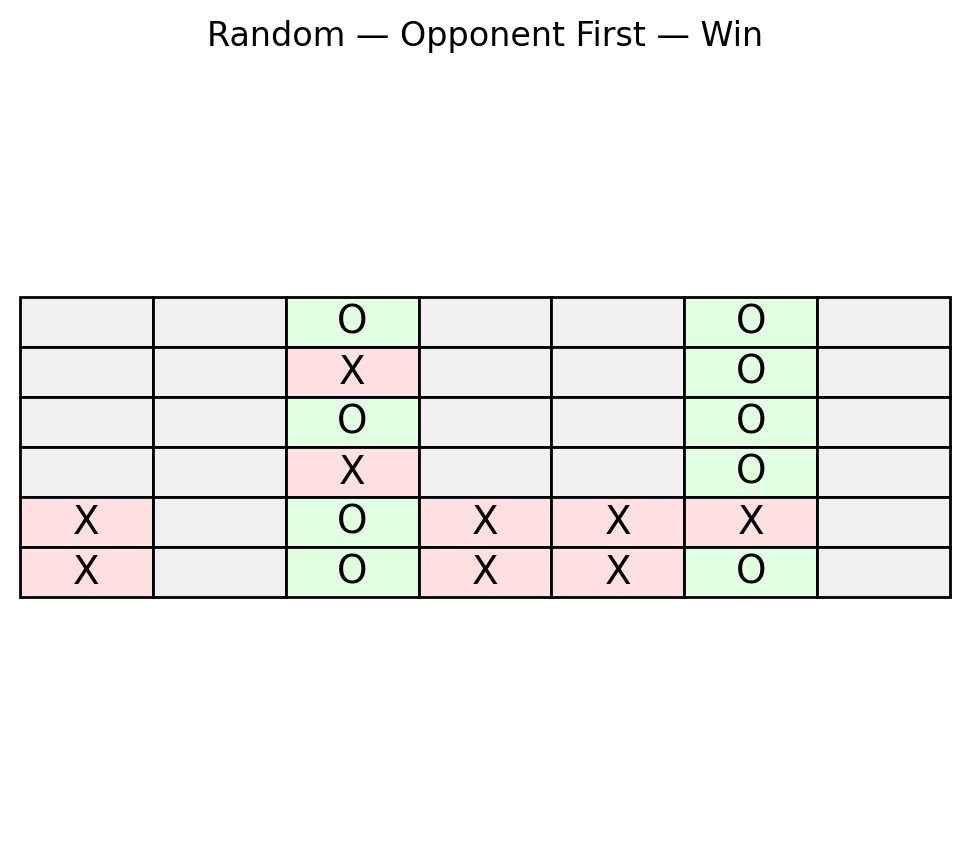

In [31]:
display_final_boards(agent, env, device, Lookahead, ["Random"])


🎯 Opponent: Lookahead-1


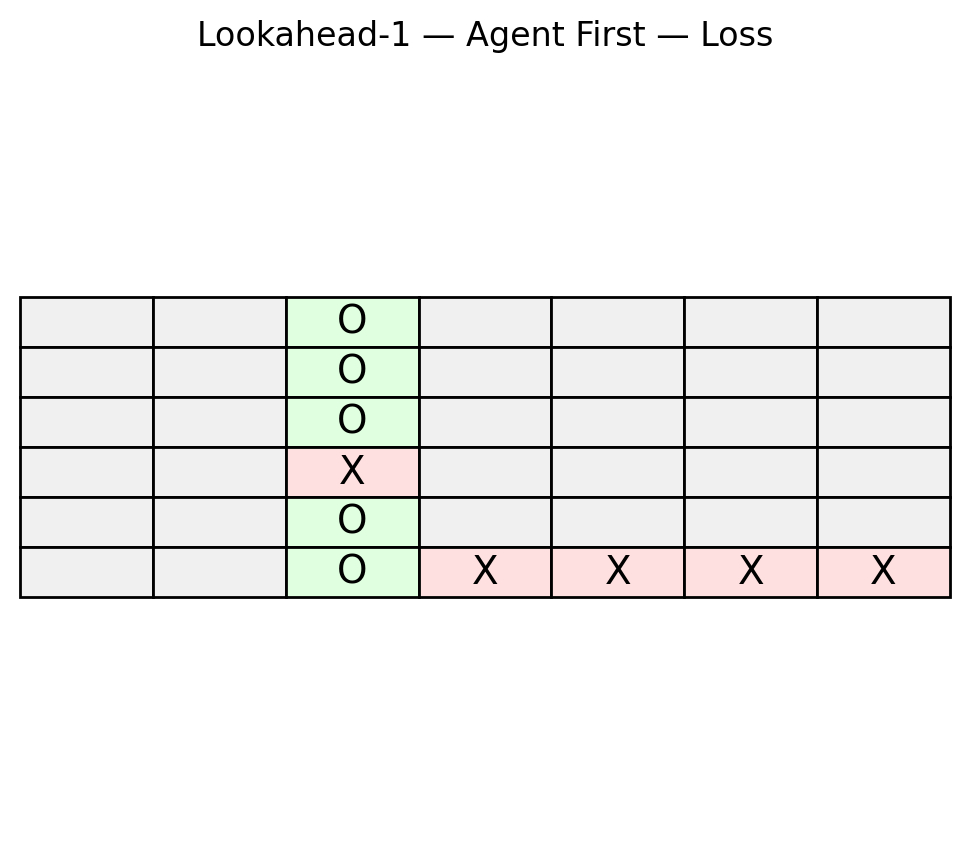

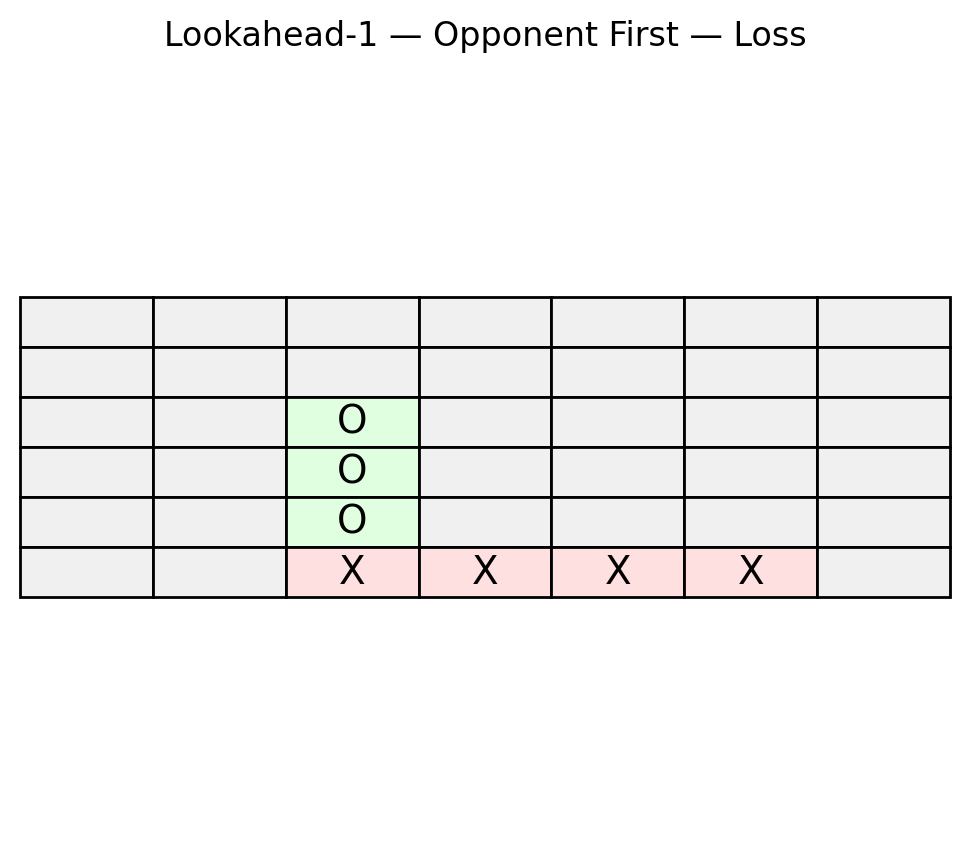

In [32]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-1"])


🎯 Opponent: Lookahead-2


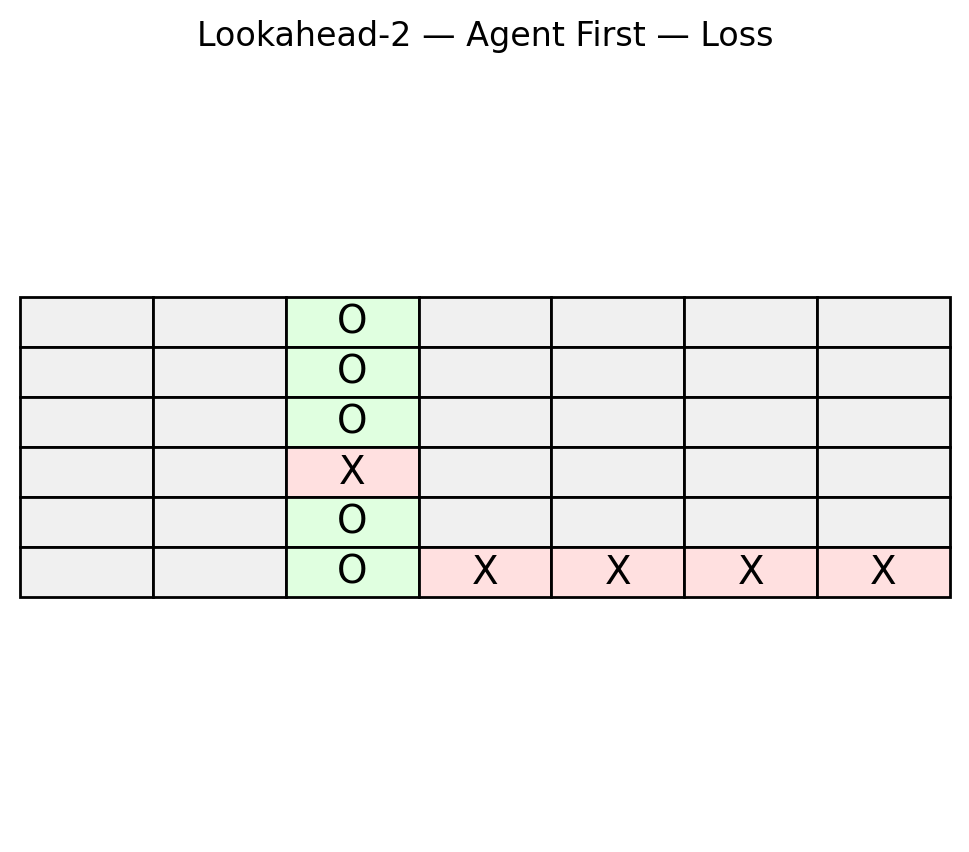

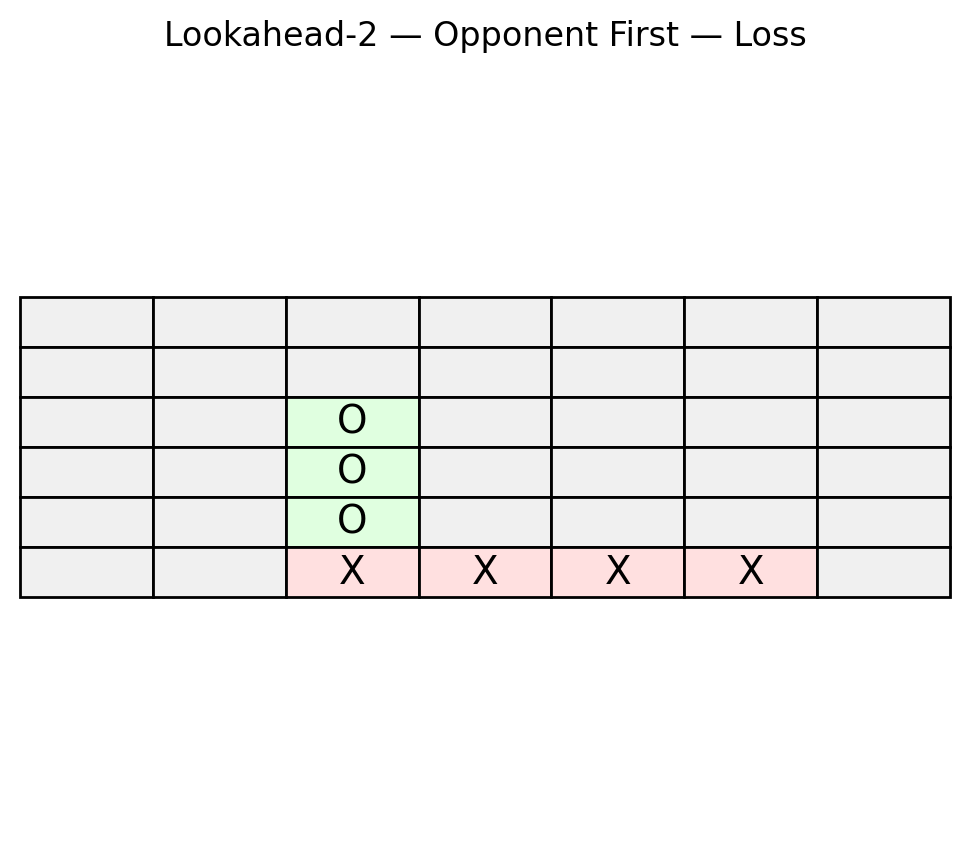

In [33]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-2"])


🎯 Opponent: Lookahead-3


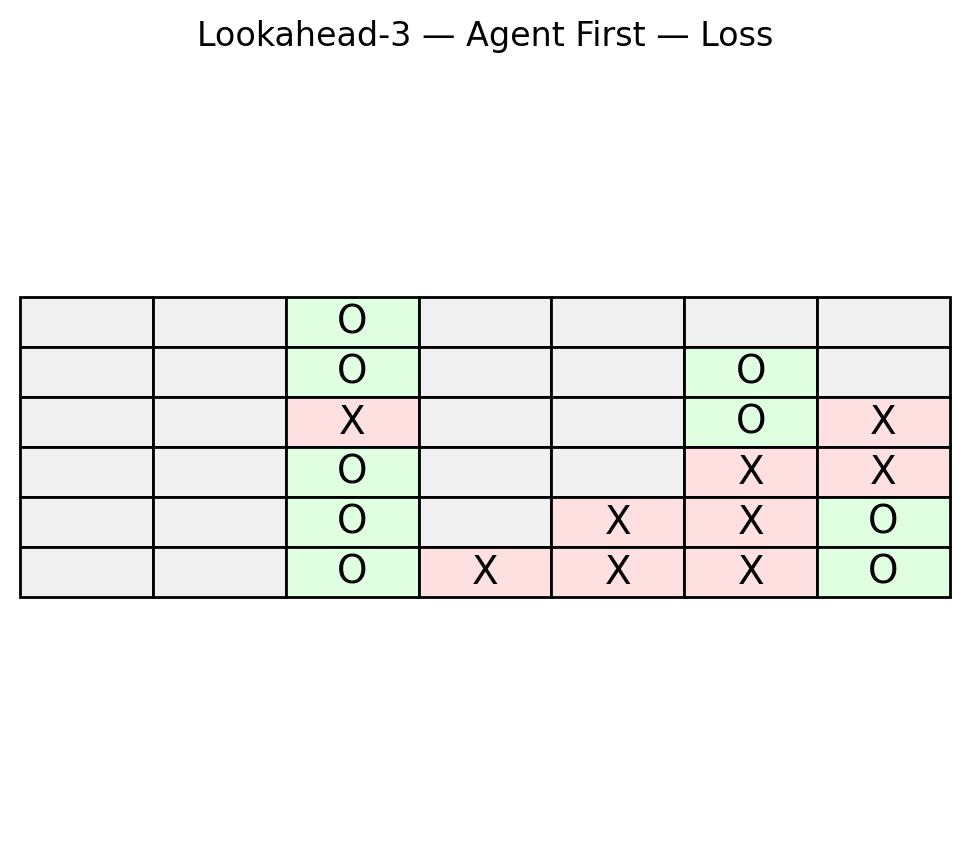

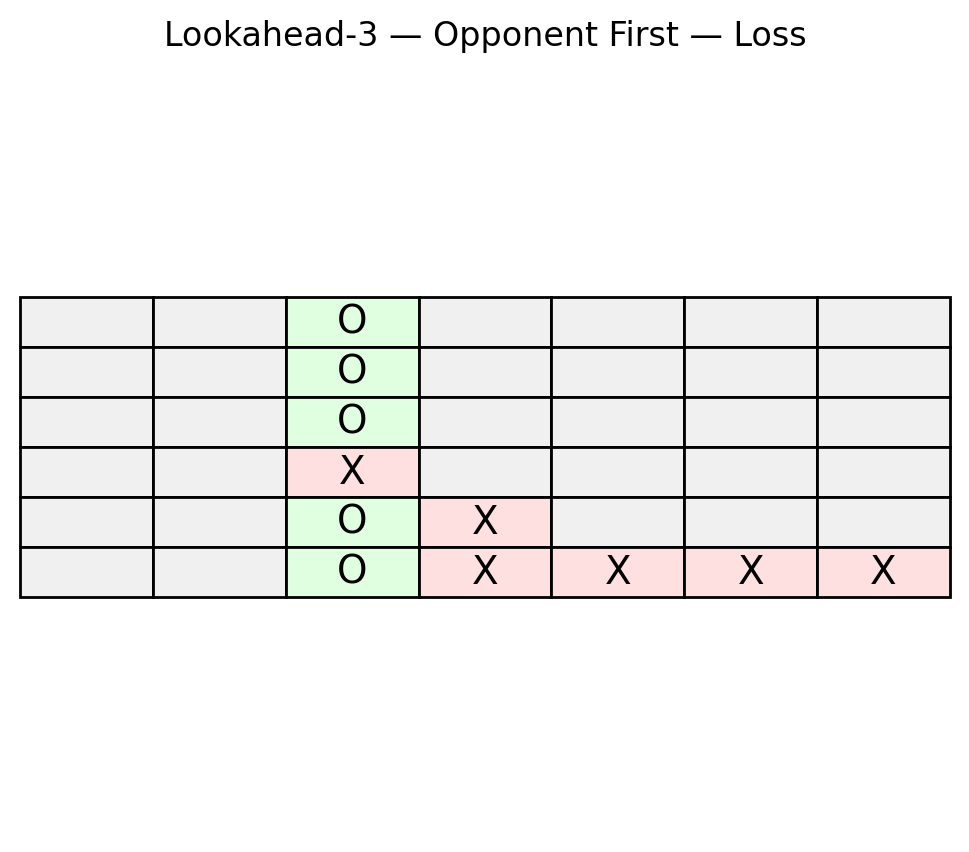

In [34]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-3"])


🎯 Opponent: Lookahead-4


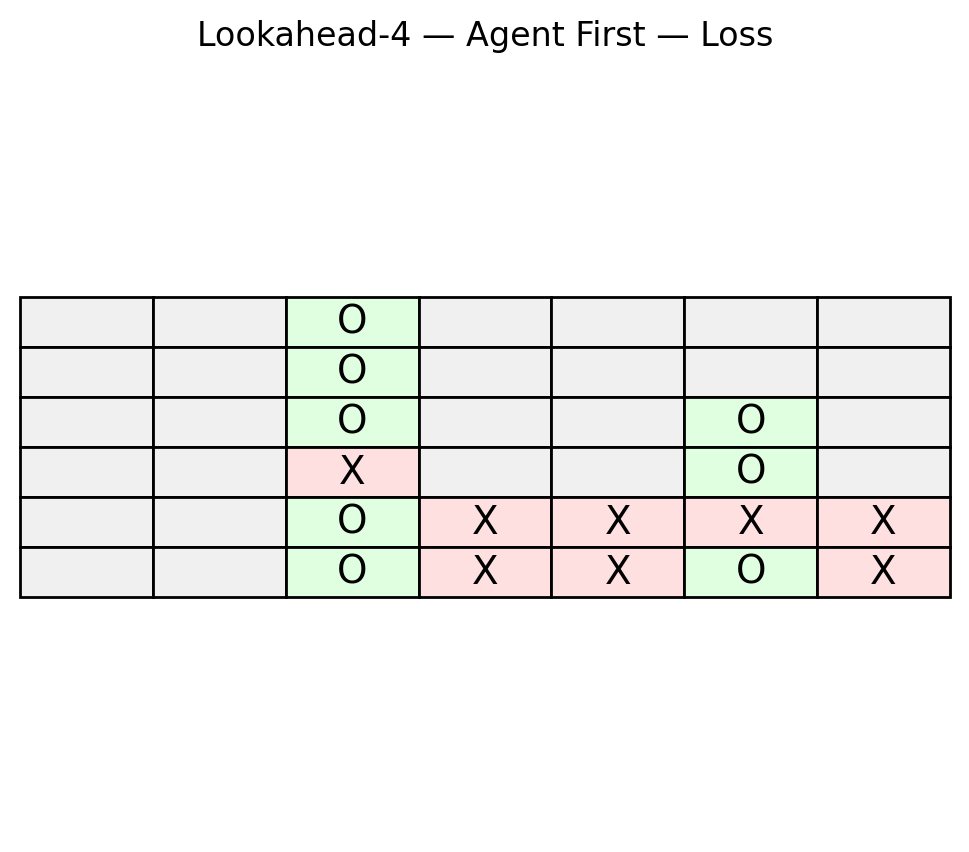

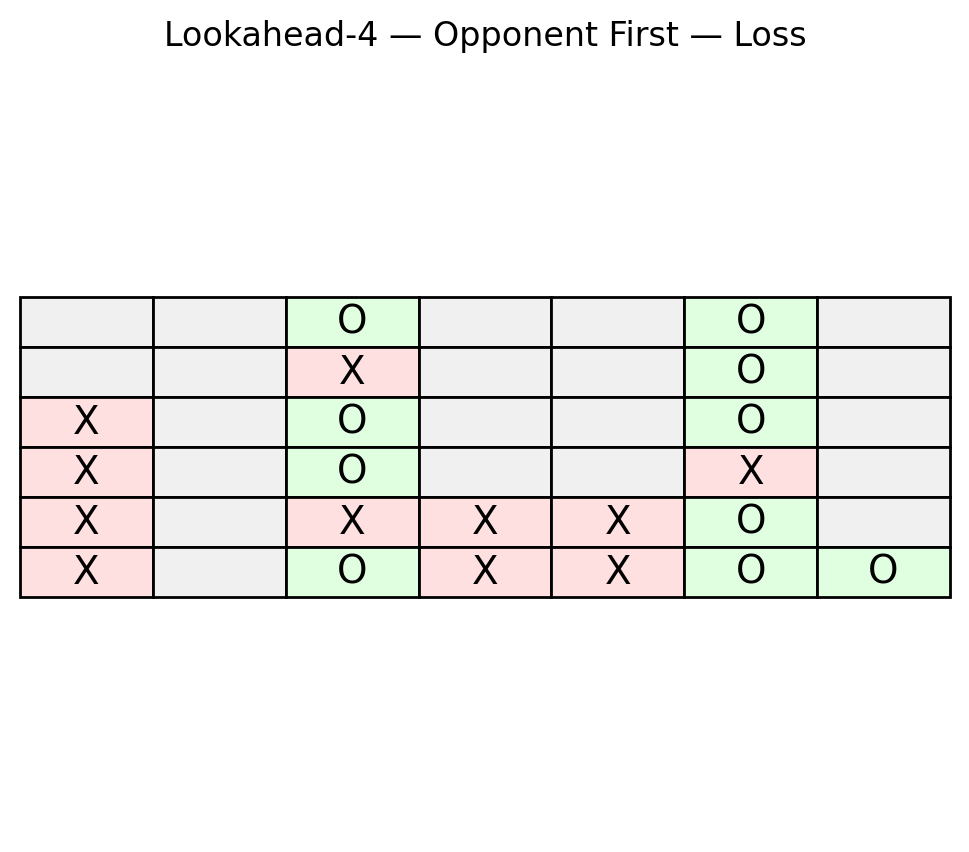

In [35]:
display_final_boards(agent, env, device, Lookahead, ["Lookahead-4"])

## Save model

In [36]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 dqn_model_{timestamp} episodes-{num_episodes}.pt"
default_model_path = "Connect4 DQN model.pt"
agent.update_target_model()  # force sync target before save

torch.save(agent.model.state_dict(), model_path)
torch.save(agent.model.state_dict(), default_model_path)
print(f"Model saved to {model_path}")


Model saved to Models/DQN/IncSeed495 - Random_Main - RANDOM III-500-TU-500-BS-128-at-2025-10-26 15-26-17_Connect4 dqn_model_20251026-163235 episodes-500.pt


# DONE

In [37]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 1.1 hours


## Training log

In [38]:
# TRAINING_SESSION

training_log_file = "DQN training_sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": num_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: DQN training_sessions.xlsx
